# SFL Small Library: HT-MEK Experimental Aggregation

In [94]:
# This will autoreload imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
from Bio import AlignIO
from Bio.Align import AlignInfo
import re
import ast
import sys
import copy
from tqdm import tqdm

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.lines import Line2D

# stats
from scipy.optimize import curve_fit
from scipy import optimize, interpolate
from scipy import stats
import scipy as scp
from scipy.stats import entropy
from sklearn.metrics import r2_score

from itertools import groupby

# parallelization
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

# file exports
import os

# import clear output function
from IPython.display import clear_output

# import custom functions
from experiment_aggregation import aggregation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Import data

Import substrate turnover data

In [95]:
# Import Experiment for AcP Substrate
df_220405_SFL_AcP = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/HT-MEK_expts/hACYP2/220405_hACYP2_9mutsWT/processed data/All_processed_data/All_processed_data220405_S2d2_Acyp2_9mutWT_scalingFactor_standardSeries_Correction.csv')
df_221022_SFL_AcP = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/221022/Interpretation/221022_AcP_workup.csv')
df_221201_SFL_AcP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/221201_SFL_203/20221201_CraigAlbert/Interpretation/AcP/221201_AcP_workup.csv')
df_230207_SFL_AcP = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/Interpretation/AcP/230207_AcP_workup.csv')
df_230410_SFL_AcP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230410_SFL_ACYPS/Interpretation/AcP/230410_AcP_workup.csv')
df_230419_SFL_AcP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/Interpretation/AcP/230419_AcP_workup.csv')
df_230612_SFL_AcP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230612_SFL_ACYPs/Interpretation/AcP/230612_AcP_workup.csv')
df_230622_SFL_AcP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230622_SFL_ACYPs/Interpretation/AcP/230622_AcP_workup.csv')
df_230629_SFL_AcP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230629_SFL_ACYPs/Interpretation/AcP/230629_AcP_workup.csv')
 
# Import Experiment for ATP Substrate
df_230419_SFL_ATP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/Interpretation/ATP/230419_ATP_workup.csv')
df_230612_SFL_ATP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230612_SFL_ACYPs/Interpretation/ATP/230612_ATP_workup.csv')
df_230622_SFL_ATP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230622_SFL_ACYPs/Interpretation/ATP/230622_ATP_workup.csv')

# Import Experiment for PEP Substrate
df_230419_SFL_PEP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/Interpretation/PEP/230419_PEP_workup.csv')
df_230612_SFL_PEP = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230612_SFL_ACYPs/Interpretation/PEP/230612_PEP_workup.csv')

Correct formatting of 4/5/22 experiment

In [96]:
# if df variable is not defined, define it
try:
    # change column name for kcat/KM
    df_220405_SFL_AcP['kcat_over_KM_fit'] = df_220405_SFL_AcP['fit_mm_kcatoverKM_MMfit']

    # replace 'Missing["Nonexistent"]' with NaN
    df_220405_SFL_AcP['kcat_over_KM_fit'] = df_220405_SFL_AcP['kcat_over_KM_fit'].replace('Missing["Nonexistent"]', np.nan)

    # convert column to float and log transform
    df_220405_SFL_AcP['log_kcat_over_KM_fit'] = df_220405_SFL_AcP['kcat_over_KM_fit'].astype(float)
    
except:
    pass


In [97]:
# Add dfs to list of dfs
all_turnover_dfs = {
                    '221022_AcP': df_221022_SFL_AcP.copy(),
                    '221201_AcP': df_221201_SFL_AcP.copy(),
                    '230207_AcP': df_230207_SFL_AcP.copy(),
                    '230410_AcP': df_230410_SFL_AcP.copy(),
                    '230419_AcP': df_230419_SFL_AcP.copy(),
                    '230612_AcP': df_230612_SFL_AcP.copy(),
                    '230622_AcP': df_230622_SFL_AcP.copy(),
                    '230629_AcP': df_230629_SFL_AcP.copy(),

                    '230419_ATP': df_230419_SFL_ATP.copy(),
                    '230612_ATP': df_230612_SFL_ATP.copy(),
                    '230622_ATP': df_230622_SFL_ATP.copy(),

                    '230419_PEP': df_230419_SFL_PEP.copy(),
                    '230612_PEP': df_230612_SFL_PEP.copy()
                      }


# add tags to each df
for key in all_turnover_dfs.keys():
    all_turnover_dfs[key] = aggregation.add_df_tags(all_turnover_dfs[key])

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['name'] = df['name'].str.replace('.', ' ')
/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['name'] = df['name'].str.replace('.', ' ')
/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* 

Import stability data

In [98]:
# Import Experiment
df_230207_SFL_DiFMUP = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/Interpretation/DiFMUP/230207_DiFMUP_workup.csv')

# add to list of dfs
all_stability_dfs = {
                    '230207_DiFMUP': df_230207_SFL_DiFMUP,
                    }

# add tags to each df
for key in all_stability_dfs.keys():
    all_stability_dfs[key] = aggregation.add_df_tags(all_stability_dfs[key])

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['name'] = df['name'].str.replace('.', ' ')


Import substrate water rate data

In [99]:
# import water rates data
df_water_rates = pd.read_csv('/Volumes/Micah_Data/HT-MEK_data/ACYP/230407_substrate_water_rates/Interpretation/230407_ACYP_substrate_water_rates_median.csv')

# format columns
df_water_rates['Substrate'] = df_water_rates['Condition'].str.split(' ').str[0]
df_water_rates['EDTA_Conc'] = df_water_rates['Condition'].str.split(' ').str[2].str[0]
df_water_rates = df_water_rates[df_water_rates['EDTA_Conc'] == '1']
df_water_rates = df_water_rates[['Substrate', 'Median Rate (uM/s)']]

Import literature rates

In [100]:
# import literature data
lit_df = pd.read_csv('/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Literature_reference/lit_collated_values.csv')

Import sequence information

In [101]:
# import protein sequences
full_protein_sequence_library = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/1_Library_Design/all-sequences-library.csv')

# import DNA sequences
full_DNA_sequence_library = pd.read_excel('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/1_Library_Design/1_Final_Order/full-optimized-oligo-library.xlsx')
full_DNA_sequence_library = full_DNA_sequence_library[['name', 'dna_sequence', 'oligo_len', 'average_ecoli_usage']]

# import single mutant log likelihoods
single_mutant_likelihoods = pd.read_csv('/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/1_Library_Design/micah-single-mutant-seqs-022723.csv')
single_mutant_likelihoods['name'] = single_mutant_likelihoods['mutation'].apply(lambda x: 'hsapiens2_' + x)

# format sequence dataframes
full_protein_sequence_library = aggregation.add_df_tags(full_protein_sequence_library)
full_DNA_sequence_library = aggregation.add_df_tags(full_DNA_sequence_library)
single_mutant_likelihoods = aggregation.add_df_tags(single_mutant_likelihoods)

# merge all sequence dataframes
full_sequence_library = full_protein_sequence_library.merge(full_DNA_sequence_library, how='left', on=np.intersect1d(full_protein_sequence_library.columns, full_DNA_sequence_library.columns).tolist())
full_sequence_library = full_sequence_library.merge(single_mutant_likelihoods, how='left', on=np.intersect1d(full_sequence_library.columns, single_mutant_likelihoods.columns).tolist())

/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['name'] = df['name'].str.replace('.', ' ')
/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['name'] = df['name'].str.replace('.', ' ')
/Users/micaholivas/Desktop/htmek_processing/multi_experiment_aggregation/experiment_aggregation/aggregation.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* 

Merge sequence information with datasets

In [102]:
# format each in all turnover dataframe
for key in all_turnover_dfs.keys():

    # remove well position from name if it exists
    pattern = r'(^\d{1,}\w{0,1}\d{1,}_)'
    for index, row in all_turnover_dfs[key].iterrows():
        if re.search(pattern, row['MutantID']):
            all_turnover_dfs[key].loc[index, 'MutantID'] = row['MutantID'].split(pattern)[0] # remove well number
            # all_turnover_dfs[key]['name'] = row['MutantID'].str.split(r'(^\d{1,}\w{0,1}\d{1,}_)', expand=True)[2] # remove well number
    
    # drop unnamed column
    if 'Unnamed: 0' in all_turnover_dfs[key].columns:
        all_turnover_dfs[key] = all_turnover_dfs[key].drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0' in full_sequence_library.columns:
        full_sequence_library = full_sequence_library.drop(columns=['Unnamed: 0'])

    # merge sequence information with each dataframe
    columns = np.intersect1d(all_turnover_dfs[key].columns, full_sequence_library.columns).tolist()
    all_turnover_dfs[key] = pd.merge(all_turnover_dfs[key], full_sequence_library, on=columns)

    # add mutation information to each dataframe if single mutant
    all_turnover_dfs[key]['mutation'] = all_turnover_dfs[key].name.str.extract(r'([A-Z]\d{1,2}[A-Z])', expand=False)

    # where name contains the string 'acylphosphatase', set species column to 'uncharacterized'
    all_turnover_dfs[key].loc[all_turnover_dfs[key]['name'].str.contains('acylphosphatase'), 'species'] = 'uncharacterized'

## Define export path

In [103]:
figure_export_path = '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/Shared drives/FordyceLab/manuscripts/Micah/Designed_AcyPs_manuscript/Plots'

### Plot n mutations for each WT background

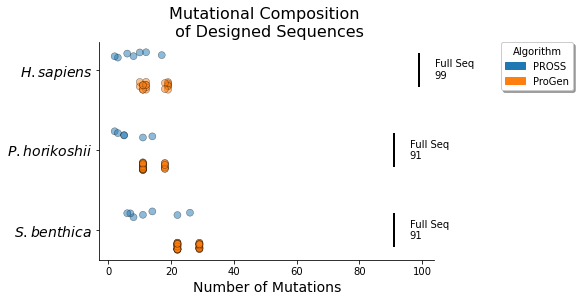

In [104]:
# pick a recent experiment to get the mutation counts
df = all_turnover_dfs[list(all_turnover_dfs.keys())[-1]]
df.drop_duplicates(subset=['name'], inplace=True)

# remove WT sequences and single mutants
df = df[df['origin'] != 'WT']
df = df[df['origin'] != 'mutant']

# get mutation counts
n_muts = df[['name', 'species', 'origin', 'n_mutations' ]]

# plot a histogram of mutation counts by origin
fig, ax = plt.subplots(figsize=(6, 4))

# filter for only hsapiens, phorikoshii, and sbenthica
n_muts = n_muts[n_muts['species'].isin(['hsapiens', 'phorikoshii', 'sbenthica'])]

# plot stripplot of mutation counts by species and make it horizonatl 
orientation = 'h'
sns.stripplot(x='n_mutations', y='species', data=n_muts, orient=orientation, 
              ax=ax, alpha=0.5, jitter=0.1, linewidth=0.5, edgecolor='k', size=7,
              order=['hsapiens', 'phorikoshii', 'sbenthica'], hue='origin', dodge=True)
sns.despine() # remove top and right borders

# change y-axis labels
ax.set_yticklabels(['$H. sapiens$', '$P. horikoshii$', '$S. benthica$'], fontsize=14)

# change labels
ax.set_ylabel('')
ax.set_xlabel('Number of Mutations', fontsize=14)
ax.set_title('Mutational Composition \n of Designed Sequences', fontsize=16)

# change markers
marker_dict = {'pross': 's', 'progen': 'o'}

# add short vertical line for the total sequence length of each species in its bin
hsapiens_tick = ax.get_yticks()[0]
hsapiens_length = 99
ax.plot([hsapiens_length, hsapiens_length], [hsapiens_tick - 0.2, hsapiens_tick + 0.2], color='k', linewidth=2)
ax.text(hsapiens_length + 5, hsapiens_tick, 'Full Seq\n' + str(hsapiens_length), verticalalignment='center')

ph_tick = ax.get_yticks()[1]
phorikoshii_length = 91
ax.plot([phorikoshii_length, phorikoshii_length], [ph_tick - 0.2, ph_tick + 0.2], color='k', linewidth=2)
ax.text(phorikoshii_length + 5, ph_tick, 'Full Seq\n' + str(phorikoshii_length), verticalalignment='center')

sb_tick = ax.get_yticks()[2]
sbenthica_length = 91
ax.plot([sbenthica_length, sbenthica_length], [sb_tick - 0.2, sb_tick + 0.2], color='k', linewidth=2)
ax.text(sbenthica_length + 5, sb_tick, 'Full Seq\n' + str(sbenthica_length), verticalalignment='center')


# Add PROSS to legend
pross_patch = mpatches.Patch(color='C0', label='PROSS')
progen_patch = mpatches.Patch(color='C1', label='ProGen')
ax.legend(handles=[pross_patch, progen_patch], bbox_to_anchor=(1.2, 1), 
          loc=2, borderaxespad=0., title='Algorithm', fancybox=True, shadow=True,
          )

# make facecolor of fig white
fig.set_facecolor('white')

# Save figure
plot_export_path = figure_export_path + '/library_design/'
if not os.path.exists(plot_export_path):
    os.makedirs(plot_export_path)
plt.savefig(plot_export_path + 'mutation_counts_by_species.png', dpi=300, bbox_inches='tight')

## Create reference dictionary for names of all sequences

In [106]:
# add design replicate column to each full_protein_sequence_libraryaframe
full_protein_sequence_library['design_rep'] = full_protein_sequence_library['name']
for index, row in full_protein_sequence_library.iterrows():
    if row['origin'] == 'progen':
        full_protein_sequence_library.loc[index, 'design_rep'] = str(row['seq_id'][0]).upper() + str(row['lambda'][0]).upper() + row['name'].split('_')[-1]
    elif row['origin'] == 'WT':
        full_protein_sequence_library.loc[index, 'design_rep'] = 'WT'
    elif row['origin'] == 'pross':
        full_protein_sequence_library.loc[index, 'design_rep'] = str(row['name'].split('_')[-1])
    elif row['origin'] == 'mutant':
        full_protein_sequence_library.loc[index, 'design_rep'] = row['mutation']
    else:
        pass

# add design replicate column to each of all_turnover_dfs
for key in all_turnover_dfs.keys():
    all_turnover_dfs[key]['design_rep'] = all_turnover_dfs[key]['name']
    for index, row in all_turnover_dfs[key].iterrows():
        if row['origin'] == 'progen':
            all_turnover_dfs[key].loc[index, 'design_rep'] = str(row['seq_id'][0]).upper() + str(row['lambda'][0]).upper() + '\n' + row['name'].split('_')[-1]
        elif row['origin'] == 'WT':
            all_turnover_dfs[key].loc[index, 'design_rep'] = 'WT'
        elif row['origin'] == 'pross':
            all_turnover_dfs[key].loc[index, 'design_rep'] = str(row['name'].split('_')[-1])
        elif row['origin'] == 'mutant':
            all_turnover_dfs[key].loc[index, 'design_rep'] = row['mutation']
        else:
            pass

Create reference dictionary for designed sequences

In [107]:
# create reference dictionary for each species
names_reference_dictionary = {}

dat = full_protein_sequence_library

# create a dictionary of all the names for each species
for species in dat['species'].unique():
    names_reference_dictionary[species] = {}
    for origin in dat['origin'].unique():
        if origin == 'WT':
            names_reference_dictionary[species][origin] = ['WT']
        else:
            ids = dat[(dat['species'] == species) & (dat['origin'] == origin)]['design_rep'].unique().tolist()
            if len(ids) > 0:
                names_reference_dictionary[species][origin] = ids

## Exponential fits

In [108]:
# initialize dictionary to store concentrations by substrate to use for k_obs curve fitting
kobs_substrate_conc_dict = {
                            'AcP': 25,
                            'ATP': 100,
                            'PEP': 100,
                            'DiFMUP': 4000
                            }

In [109]:
# from tqdm import tqdm

# for key in tqdm(all_turnover_dfs.keys(), desc='Outer Loop'):
#     for substrate, conc in tqdm(kobs_substrate_conc_dict.items(), desc='Inner Loop'):
#         if substrate in key:
#             kobs_conc = conc
#             # generate kobs column in new dataframe and fit kobs curves
#             all_turnover_dfs[key] = aggregation.get_exponentials(all_turnover_dfs[key], kobs_conc)

In [110]:
# normalize kobs by enzyme concentration
for key in all_turnover_dfs.keys():
    if 'k_obs' in all_turnover_dfs[key].columns:
        all_turnover_dfs[key]['kobs_over_enzyme_conc'] = all_turnover_dfs[key]['k_obs'] / all_turnover_dfs[key]['EnzymeConc']
    else:
        all_turnover_dfs[key]['kobs_over_enzyme_conc'] = np.nan

all_turnover_dfs['221022_AcP'][['MutantID', 'Indices', 'EnzymeConc', 'substrate_conc_uM', 'k_obs', 'kobs_over_enzyme_conc']]

KeyError: "['k_obs'] not in index"

### Compare effects of SDS wash on background rates

In [ ]:
# import Decimal
from decimal import Decimal

# import Patch
from matplotlib.patches import Patch

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/2659617490.py:44: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  dat_p = pd.concat(dat.values(), ignore_index=True)


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (5).

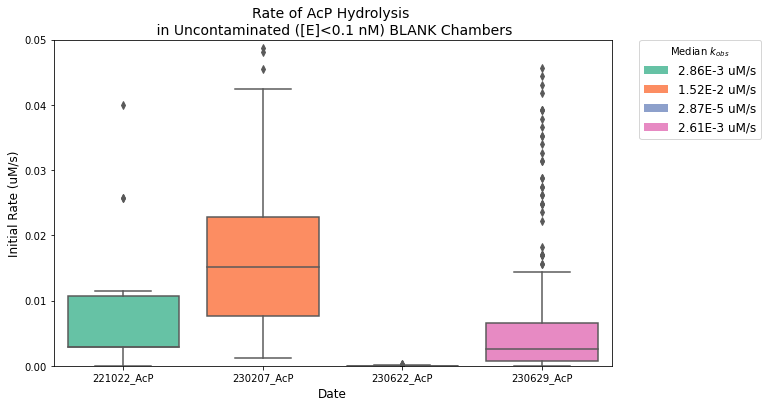

In [111]:
substrate = 'AcP'
substrate_conc = 100
low_enzyme_conc = 0.1

# get the data from list of experiments
dat = {'221022_AcP': df_221022_SFL_AcP,
       '230207_AcP': df_230207_SFL_AcP,
    #    '230419_AcP': df_230419_SFL_AcP,
       '230612_AcP': df_230612_SFL_AcP,
       '230622_AcP': df_230622_SFL_AcP,
       '230629_AcP': df_230629_SFL_AcP,
         
       '230419_ATP': df_230419_SFL_ATP,
       '230612_ATP': df_230612_SFL_ATP,
       '230622_ATP': df_230622_SFL_ATP,

       '230419_PEP': df_230419_SFL_PEP,
       '230612_PEP': df_230612_SFL_PEP,
       }

# filter the data
for key in dat.keys():
    # remove non-BLANK chambers
    dat[key] = dat[key][dat[key]['MutantID'] == 'BLANK']

    # remove substrate concentrations that are not 10
    dat[key] = dat[key][dat[key]['substrate_conc_uM'] == substrate_conc]

    # remove data that above a given Enzyme Concentration
    dat[key] = dat[key][dat[key]['EnzymeConc'] <= low_enzyme_conc]

# filter the data by substrate
all_keys = list(dat.keys())
for key in all_keys:
    if substrate not in key:
        dat.pop(key)

# remove negative rates
for key in dat.keys():
    dat[key] = dat[key][dat[key]['initial_rate'] > 0]


# concatenate the data into one df
dat_p = pd.concat(dat.values(), ignore_index=True)

# split GlobalExperimentIndex into date column; join first and last items from split
dat_p['date_sub'] = dat_p['GlobalExperimentIndex'].str.split('_').str[0] + '_' + dat_p['GlobalExperimentIndex'].str.split('_').str[-1]

# setup plot
length = len(dat.keys())
fig, ax = plt.subplots(figsize=(length * 2, 6))

# plot the data
sns.boxplot(x='date_sub', y='initial_rate', data=dat_p, ax=ax, palette='Set2')


# add title, x and y labels, and limit the y axis
ax.set_title('Rate of %s Hydrolysis \n in Uncontaminated ([E]<%s nM) BLANK Chambers' % (substrate, low_enzyme_conc), fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Initial Rate (uM/s)', fontsize=12)
ax.set_ylim(0, 0.05)

# get median values
medians = dat_p.groupby(['date_sub'])['initial_rate'].median().values

# set patches for legend to be the same colors as the boxplot
for patch, color in zip(ax.artists, sns.color_palette('Set2')):
    patch.set_facecolor(color)

# create a legend to show median values in scientific notation
legend_elements = [Patch(facecolor=sns.color_palette('Set2')[i], label='%s uM/s' % (format(Decimal(medians[i]), '.2E'))) for i in range(len(medians))]

# add legend to plot
ax.legend(handles=legend_elements, title = 'Median $k_{obs}$', fontsize=12, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# manually set xtick labels from dictionary
if substrate == 'AcP':
    dict_ref = {'221022_AcP': '—SDS Wash \n —EDTA \n 22/10/22',
                '230207_AcP': '—SDS Wash \n +EDTA \n 23/02/07',
                # '230419_AcP': '-SDS Wash \n 23/04/19',
                '230612_AcP': '+SDS Wash \n +EDTA \n 23/06/12',
                '230622_AcP': '+SDS Wash \n +EDTA \n 23/06/22',
                '230629_AcP': '+SDS Wash \n +EDTA \n 23/06/29',
                }
    
elif substrate == 'ATP':
    dict_ref = {'230419_ATP': '—SDS Wash \n 23/04/19',
                '230612_ATP': '+SDS Wash \n 23/06/12',
                '230622_ATP': '+SDS Wash \n 23/06/22',
                }
    
elif substrate == 'PEP':
    dict_ref = {'230419_PEP': '—SDS Wash \n 23/04/19',
                '230612_PEP': '+SDS Wash \n 23/06/12',
                }

# add white background to figure
fig.patch.set_facecolor('white')

ax.set_xticklabels(dict_ref.values(), rotation=0)

### Comprate kobs in presence of SDS

In [112]:
# get dictionary of SDS washes. 1 is +SDS Wash, 0 is -SDS Wash
substrate = 'AcP'
if substrate == 'AcP':
    dict_ref = {'221022_AcP': 0,
                '221201_AcP': 0,
                '230207_AcP': 0,
                # '230419_AcP': '-SDS Wash',
                '230612_AcP': 1,
                '230622_AcP': 1,
                '230629_AcP': 1,

                }
    
elif substrate == 'ATP':
    dict_ref = {'230419_ATP': 0,
                '230612_ATP': 1,
                '230622_ATP': 1,
                }
    
elif substrate == 'PEP':
    dict_ref = {'230419_PEP': 0,
                '230612_PEP': 1,
                }
    
# get list of tuples with combinations of experiments, only if they have opposite SDS washes
from itertools import combinations
combs = list(combinations(dict_ref.keys(), 2))
combs = [comb for comb in combs if dict_ref[comb[0]] != dict_ref[comb[1]]]
combs

[('221022_AcP', '230612_AcP'),
 ('221022_AcP', '230622_AcP'),
 ('221022_AcP', '230629_AcP'),
 ('221201_AcP', '230612_AcP'),
 ('221201_AcP', '230622_AcP'),
 ('221201_AcP', '230629_AcP'),
 ('230207_AcP', '230612_AcP'),
 ('230207_AcP', '230622_AcP'),
 ('230207_AcP', '230629_AcP')]

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/1912938700.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df = pd.merge(experiment1, experiment2, on='MutantID')
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/1912938700.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df = pd.merge(experiment1, experiment2, on='MutantID')
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/1912938700.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may i

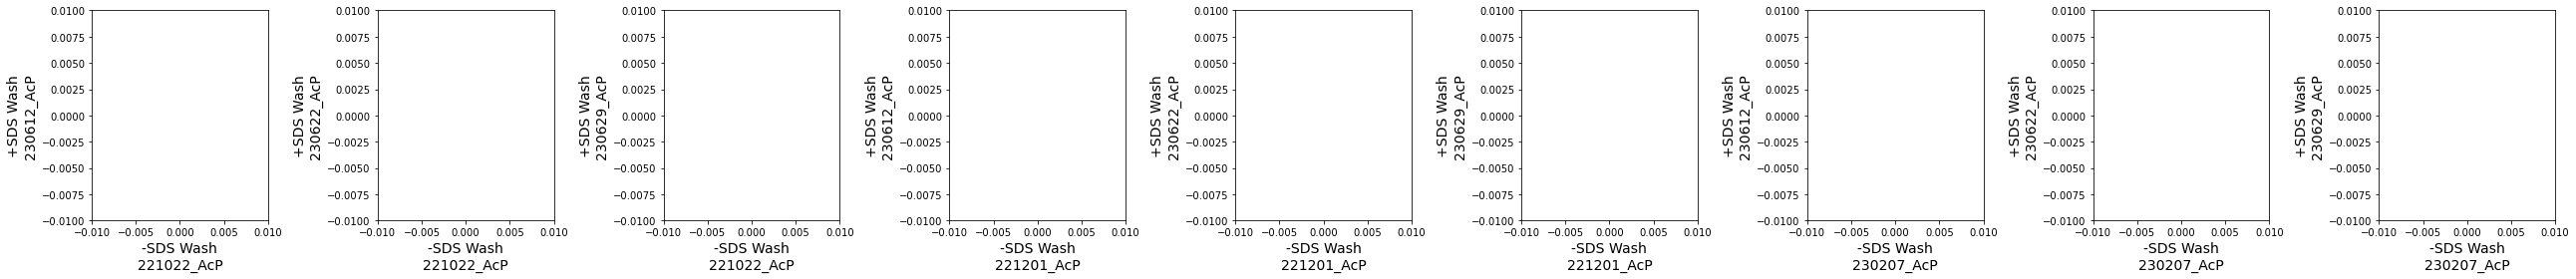

In [113]:
# plot each combination of experiments
fig, axs = plt.subplots(1, len(combs), figsize=(len(combs) * 4, 4))

# loop through each combination of experiments
for i, comb in enumerate(combs):
    # if both experiments are in the all_turnover_dfs dictionary
    if comb[0] in all_turnover_dfs.keys() and comb[1] in all_turnover_dfs.keys():
        # get data for each experiment
        experiment1 = all_turnover_dfs[comb[0]]
        experiment2 = all_turnover_dfs[comb[1]]

        # create a column for experiment name
        experiment1['experiment'] = comb[0]
        experiment2['experiment'] = comb[1]

        # remove points with local_bg_ratio < 2
        experiment1 = experiment1[experiment1['local_bg_ratio'] > 2]
        experiment2 = experiment2[experiment2['local_bg_ratio'] > 2]

        # get medians and stds for each MutantID in each experiment
        experiment1 = experiment1[['MutantID', 'kobs_over_enzyme_conc']].groupby('MutantID').agg({'kobs_over_enzyme_conc': ['median', 'std']}).reset_index()
        experiment2 = experiment2[['MutantID', 'kobs_over_enzyme_conc']].groupby('MutantID').agg({'kobs_over_enzyme_conc': ['median', 'std']}).reset_index()

        # merge dataframes on MutantID, and only keep columns: Indices, kcat/KM median, kcat/KM std
        merged_df = pd.merge(experiment1, experiment2, on='MutantID')

        # now convert multiindex columns to single index
        merged_df.columns = ['MutantID', 'kobs_over_enzyme_conc_median_1', 'kobs_over_enzyme_conc_std_1', 'kobs_over_enzyme_conc_median_2', 'kobs_over_enzyme_conc_std_2']

        # plot k_obs values for each experiment
        axs[i].errorbar(merged_df['kobs_over_enzyme_conc_median_1'], merged_df['kobs_over_enzyme_conc_median_2'], 
                        xerr=merged_df['kobs_over_enzyme_conc_std_1'], yerr=merged_df['kobs_over_enzyme_conc_std_2'],
                        fmt='o', color='k', alpha=0.5, markersize=5, linewidth=0.5, capsize=2)
        
    # add x label and y label, including the SDS wash status of each experiment
    # convert 1 and 0 to +SDS Wash and -SDS Wash
    if dict_ref[comb[0]] == 1:
        comb0 = '+SDS Wash'
    elif dict_ref[comb[0]] == 0:
        comb0 = '-SDS Wash'
    if dict_ref[comb[1]] == 1:
        comb1 = '+SDS Wash'
    elif dict_ref[comb[1]] == 0:
        comb1 = '-SDS Wash'
    # add bolding to the SDS wash status of each experiment
    axs[i].set_xlabel(comb0 + '\n' + comb[0], fontsize=14)
    axs[i].set_ylabel(comb1 + '\n' + comb[1], fontsize=14)

    # reduce x and y limits
    axs[i].set_xlim(-0.01, 0.01)
    axs[i].set_ylim(-0.01, 0.01)

plt.tight_layout()

### Plot a boxplot of HypF kobs

In [114]:
# combine all AcP data into one df
combined_acp_df = pd.DataFrame()
for key in all_turnover_dfs.keys():
    if 'AcP' in key:
        if combined_acp_df.empty:
            combined_acp_df = all_turnover_dfs[key]
            combined_acp_df['experiment'] = key
        else:
            # add experiment column to all_turnover_dfs[key]
            all_turnover_dfs[key]['experiment'] = key
            combined_acp_df = pd.concat([combined_acp_df, all_turnover_dfs[key]], ignore_index=True)


# normalize k_obs values by EnzymeConc
combined_acp_df['k_obs_norm'] = combined_acp_df['k_obs'] / combined_acp_df['EnzymeConc']

## filter data                                  
# drop nans from k_obs column
combined_acp_df = combined_acp_df.dropna(subset=['k_obs'])

# # remove poorly expressed variants
# combined_acp_df = combined_acp_df[combined_acp_df['EnzymeConc'] > 1]

# remove low k_obs R squared values
combined_acp_df = combined_acp_df[combined_acp_df['Rsq_kobs'] > 0.95]

# remove variants with low local bg ratio
combined_acp_df = combined_acp_df[combined_acp_df['local_bg_ratio'] > 2]

KeyError: 'k_obs'

In [115]:
# remove experiments 
combined_acp_df = combined_acp_df[combined_acp_df['experiment'] != '230419_AcP']
combined_acp_df = combined_acp_df[combined_acp_df['experiment'] != '230410_AcP']

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/4205766273.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['median_k_obs'] = dat.groupby('MutantID')['kobs_over_enzyme_conc'].transform('median')


KeyError: 'k_obs_norm'

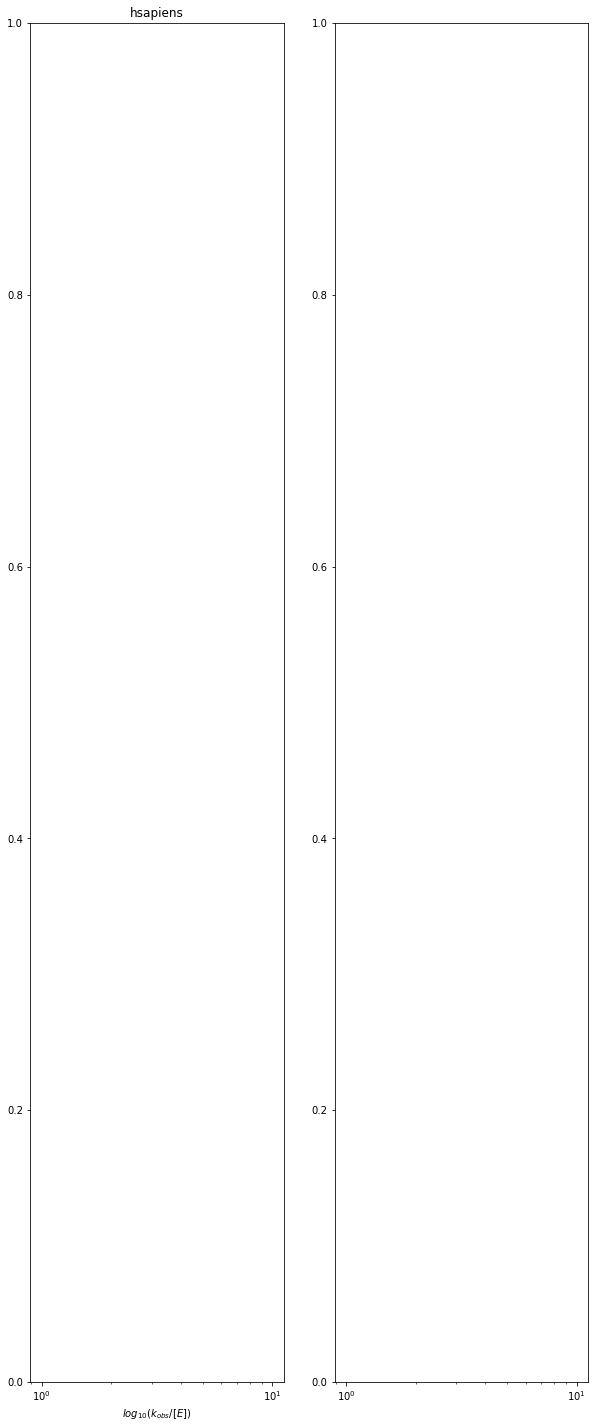

In [116]:
# two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 25), sharex=True)

# left plot hsapiens, right plot hypf
for i, species in enumerate(['hsapiens', 'sbenthica']):
    axs[i].set_title(species)
    axs[i].set_xlabel('$log_{10}(k_{obs}/[E])$')
    axs[i].set_ylabel('')
    axs[i].set_xscale('log')

    # get data for species
    dat = combined_acp_df[combined_acp_df['species'] == species]

    # calculate median k_obs for each mutantid and store in new column
    dat['median_k_obs'] = dat.groupby('MutantID')['kobs_over_enzyme_conc'].transform('median')

    # sort by median k_obs
    dat = dat.sort_values(by='median_k_obs', ascending=False)

    # plot stripplot of k_obs norm by each mutantid
    im = axs[i].scatter(dat['k_obs_norm'], dat['MutantID'], s=30, alpha=0.3, c=dat['local_bg_ratio'], cmap='viridis')

    # add colorbar below x axis
    fig.colorbar(im, ax=axs[i], orientation='horizontal', label='local background ratio', pad=0.05)

    # add text to show how many points are in each plot
    axs[i].text(0.05, 0.99, 'n = ' + str(len(dat)), transform=axs[i].transAxes, verticalalignment='top')

# move hypf labels to the right
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")

## Initial filtering

In [117]:
# define cutoffs for filtering
# local_bg_ratio_cutoff = 1.8
# kcat_KM_R2_cutoff = 0.9
# kcat_KM_cutoff = 1e5 # M^-1 s^-1
enzyme_concentration_cutoff = 1 # nM


# filter out chambers with low local bg ratio
for key, value in all_turnover_dfs.items():
    # all_turnover_dfs[key] = all_turnover_dfs[key][all_turnover_dfs[key]['local_bg_ratio'] > local_bg_ratio_cutoff]

    # add a column to contain limit information
    for index, row in all_turnover_dfs[key].iterrows():
        if row['local_bg_ratio'] > local_bg_ratio_cutoff:
            all_turnover_dfs[key].loc[index, 'limit'] = 'none'
        else:
            all_turnover_dfs[key].loc[index, 'limit'] = 'lower'

# # filter out variants with low kcat/KM R^2
# for key, value in all_turnover_dfs.items():
#     if 'kcat_over_KM_R2' in all_turnover_dfs[key].columns:
#         all_turnover_dfs[key] = all_turnover_dfs[key][all_turnover_dfs[key]['kcat_over_KM_fit_R2'] > kcat_KM_R2_cutoff]

# # filter out variants with very high kcat/KM values
# for key, value in all_turnover_dfs.items():
#     all_turnover_dfs[key] = all_turnover_dfs[key][all_turnover_dfs[key]['kcat_over_KM_fit'] < kcat_KM_cutoff]

# filter out egfp flagged variants
for key, value in all_turnover_dfs.items():
    if 'egfp_manual_flag' in all_turnover_dfs[key].columns:
        all_turnover_dfs[key] = all_turnover_dfs[key][all_turnover_dfs[key]['egfp_manual_flag'] == False]

# # filter out low expression variants
# for key, value in all_turnover_dfs.items():
#     all_turnover_dfs[key] = all_turnover_dfs[key][all_turnover_dfs[key]['EnzymeConc'] > enzyme_concentration_cutoff]

### Generate median dfs

In [118]:
# get list of substrates
substrates = []
for key, value in all_turnover_dfs.items():
    substrates.append(all_turnover_dfs[key]['substrate'].unique()[0])
substrates = np.unique(substrates)

# remove experiments if desired
dat = all_turnover_dfs.copy()

# for each substrate, get median kcat/KM values
turnover_median_dfs = {}
for substrate in substrates:
    for key, value in dat.items():

        # append kcat/KM values to list if substrate is in key
        if substrate in key:
            dat[key]['experiment'] = key
            if turnover_median_dfs.get(substrate) is None:
                turnover_median_dfs[substrate] = dat[key]
            else:
                turnover_median_dfs[substrate] = pd.concat([turnover_median_dfs[substrate], all_turnover_dfs[key]])
            
    # get median and std
    turnover_median_dfs[substrate] = turnover_median_dfs[substrate][['name', 'ensemble_ll', 'predicted_tm', 'species', 'origin', 'kcat_over_KM_fit']].groupby(['name', 'ensemble_ll', 'predicted_tm', 'species', 'origin']).agg({'kcat_over_KM_fit': ['median', 'std']}).reset_index()
    turnover_median_dfs[substrate].columns = ['name', 'ensemble_ll', 'predicted_tm', 'species', 'origin', 'kcat_over_KM_fit_median', 'kcat_over_KM_fit_std']

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/663932597.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[key]['experiment'] = key


## Plot kcat/KM replicates

First, log transform all kcat/KM values

In [119]:
# loop through keys and transform kcat/KM values
for key in all_turnover_dfs.keys():
    all_turnover_dfs[key]['kcat_over_KM_fit'] = np.log10(all_turnover_dfs[key]['kcat_over_KM_fit'])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/433700203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_turnover_dfs[key]['kcat_over_KM_fit'] = np.log10(all_turnover_dfs[key]['kcat_over_KM_fit'])
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Next plot the log transformed values

In [120]:
# remove some experiments
experiments_to_remove = [
                        '221022_AcP',
                        '230612_AcP',
                        '230622_AcP',
                        # '230629_AcP', 
                        ]

dat = all_turnover_dfs.copy()
for key in experiments_to_remove:
    dat.pop(key)

# # remove high and low kcat/KM values
# for key, value in dat.items():
#     dat[key] = dat[key][dat[key]['kcat_over_KM_fit'] > 1]
#     dat[key] = dat[key][dat[key]['kcat_over_KM_fit'] < 6]


In [121]:
all_turnover_dfs['230612_AcP'].columns

Index(['x', 'y', 'Indices', 'MutantID', 'substrate', 'EnzymeConc',
       'egfp_manual_flag', 'substrate_concs', 'initial_rates', 'KM_fit',
       'vmax_fit', 'kcat_fit', 'kcat_over_KM_fit', 'kcat_over_KM_fit_R2',
       'local_bg_ratio', 'substrate_conc_uM',
       'summed_button_BGsub_Button_Quant', 'time_s',
       'kinetic_median_intensities', 'standard_concentration_uM',
       'standard_median_intensities', 'standard_popt',
       'kinetic_product_concentration_uM', 'initial_rate',
       'initial_rate_intercept', 'two_point_fit', 'rate_fit_regime',
       'GlobalExperimentIndex', 'Experiment', 'name', 'mutation', 'species',
       'origin', 'sampling_replicate', 'lambda', 'seq_id', 'n_mutations',
       'ensemble_ll', 'predicted_tm', 'protein_sequence',
       'protein_sequence_wt', 'dna_sequence', 'oligo_len',
       'average_ecoli_usage', 'progen2-base', 'progen2-medium',
       'progen2-large', 'design_rep', 'kobs_over_enzyme_conc', 'experiment',
       'limit'],
      dtype=

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/3369698351.py:48: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df = pd.merge(experiment1, experiment2, on='MutantID')
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/3369698351.py:48: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df = pd.merge(experiment1, experiment2, on='MutantID')
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/3369698351.py:48: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df = pd.merge(experiment1, experiment2, on='MutantID')
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/3369698351.py:48: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df = pd.merge(experiment1, 

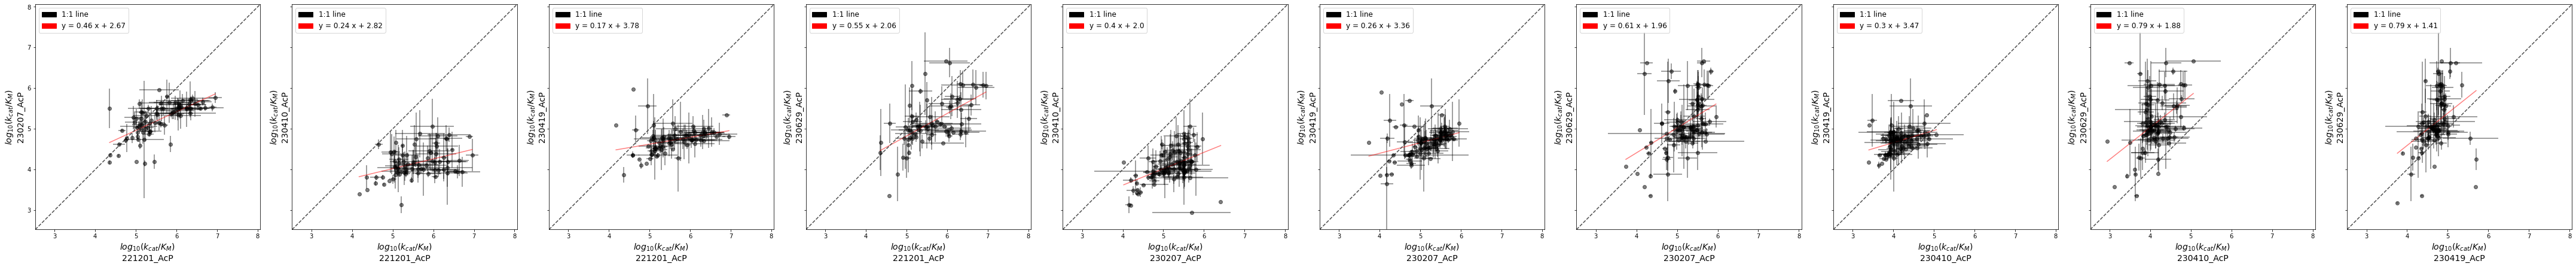

In [122]:
import itertools

## make a grid of plots comparing kcat/KM in each experiment to each other
# choose a substrate
substrate = 'AcP'

# get list of all unique pairs of experiments
current_substrate_experiments = {key: value for key, value in dat.items() if substrate in key}
experiment_pairs = list(itertools.combinations(current_substrate_experiments.keys(), 2))

# set size of figure
scale = 6
plt.rcParams['figure.figsize'] = [len(experiment_pairs) * scale, scale]

# create figure with subplots
fig, axs = plt.subplots(1, len(experiment_pairs), sharex=True, sharey=True)


# loop through each pair of experiments
for i, experiment_pair in enumerate(experiment_pairs):
    # get data for each experiment
    experiment1 = dat[experiment_pair[0]]
    experiment2 = dat[experiment_pair[1]]

    # create a column for experiment name
    experiment1['experiment'] = experiment_pair[0]
    experiment2['experiment'] = experiment_pair[1]

    # remove points with local_bg_ratio < 2
    experiment1 = experiment1[experiment1['local_bg_ratio'] > 2]
    experiment2 = experiment2[experiment2['local_bg_ratio'] > 2]

    # remove low kcat/KM R^2 values
    if 'kcat_over_KM_R2' in experiment1.columns:
        experiment1 = experiment1[experiment1['kcat_over_KM_fit_R2'] > 0.99]
        experiment2 = experiment2[experiment2['kcat_over_KM_fit_R2'] > 0.99]

    # remove low enzyme concentration values
    if 'EnzymeConc' in experiment1.columns:
        experiment1 = experiment1[experiment1['EnzymeConc'] > 1]
        experiment2 = experiment2[experiment2['EnzymeConc'] > 1]

    # get medians and stds for each MutantID in each experiment
    experiment1 = experiment1[['MutantID', 'kcat_over_KM_fit']].groupby('MutantID').agg({'kcat_over_KM_fit': ['median', 'std']}).reset_index()
    experiment2 = experiment2[['MutantID', 'kcat_over_KM_fit']].groupby('MutantID').agg({'kcat_over_KM_fit': ['median', 'std']}).reset_index()

    # merge dataframes on MutantID, and only keep columns: Indices, kcat/KM median, kcat/KM std
    merged_df = pd.merge(experiment1, experiment2, on='MutantID')

    # now convert multiindex columns to single index
    merged_df.columns = ['MutantID', 'kcat_over_KM_fit_median_x', 'kcat_over_KM_fit_std_x', 'kcat_over_KM_fit_median_y', 'kcat_over_KM_fit_std_y']

    # plot kcat/KM values from each experiment against each other
    axs[i].errorbar(merged_df['kcat_over_KM_fit_median_x'], merged_df['kcat_over_KM_fit_median_y'], xerr=merged_df['kcat_over_KM_fit_std_x'], yerr=merged_df['kcat_over_KM_fit_std_y'], fmt='o', color='black', alpha=0.5)
    
    # make plot square
    axs[i].set_aspect('equal', 'box')

    # set x and y labels
    axs[i].set_xlabel('$log_{10}(k_{cat}/K_M)$ \n' + experiment_pair[0], fontsize=14)
    axs[i].set_ylabel('$log_{10}(k_{cat}/K_M)$ \n' + experiment_pair[1], fontsize=14)

    # make axis limits equal at 1.1 * max
    ylim = axs[i].get_ylim()
    xlim = axs[i].get_xlim()
    axs[i].set_ylim(0.95 * max(ylim[0], xlim[0]), 1.01 * max(ylim[1], xlim[1]))
    axs[i].set_xlim(0.95 * max(ylim[0], xlim[0]), 1.01 * max(ylim[1], xlim[1]))


    # plot regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['kcat_over_KM_fit_median_x'], merged_df['kcat_over_KM_fit_median_y'])
    x = np.linspace(merged_df['kcat_over_KM_fit_median_x'].min(), merged_df['kcat_over_KM_fit_median_x'].max(), 100)
    axs[i].plot(x, slope * x + intercept, color='red', alpha=0.5)

    # add legend to show regression line equation
    patches = [
                mpatches.Patch(color='black', label='1:1 line'),
                mpatches.Patch(color='red', label='y = %s x + %s' % (slope.round(2), intercept.round(2)))
                ]
    axs[i].legend(handles=patches, loc='upper left', fontsize=12)

for i in range(len(experiment_pairs)):
    # plot 1:1 line
    axs[i].plot(axs[i].get_xlim(), axs[i].get_ylim(), ls="--", c=".3")

# tight layout
plt.tight_layout()

# make face white
fig.patch.set_facecolor('white')

# save png
plot_export_path = figure_export_path + '/Catalysis/experiment_replicates/'

if not os.path.exists(os.path.dirname(plot_export_path)):
    os.makedirs(os.path.dirname(plot_export_path))

plt.savefig(plot_export_path + 'kcat_over_KM_expt_replicates.png', dpi=300, bbox_inches='tight')

Plot only human single mutant box and whisker

In [123]:
df_processed_220405_AcP = df_220405_SFL_AcP[['MutantID', 'kcat_over_KM_fit', 'LocalBackgroundRatio', 'fit_mm_curved_r2' , 'EnzymeConc']]

# change string R98A to R97A in mutant ID
df_processed_220405_AcP['MutantID'] = df_processed_220405_AcP['MutantID'].apply(lambda x: x.replace('R98A', 'R97A'))

# add species column
df_processed_220405_AcP['species'] = 'hsapiens'

# add mutation column
df_processed_220405_AcP['mutation'] = df_processed_220405_AcP['MutantID'].apply(lambda x: x.split('_')[0])

# add origin column: this is WT when mutation is WT, BLANK when mutation is BLANK, and mutant otherwise
df_processed_220405_AcP['origin'] = df_processed_220405_AcP['mutation'].apply(lambda x: 'WT' if x == 'WT' else 'BLANK' if x == 'BLANK' else 'mutant')

# add experiment column
df_processed_220405_AcP['experiment'] = '220405_AcP'

# add substrate column
df_processed_220405_AcP['substrate'] = 'AcP'

# change non float values in kcat_over_KM_fit, local background ratio, r2, and enzyme conc to NaN
df_processed_220405_AcP['kcat_over_KM_fit'] = pd.to_numeric(df_processed_220405_AcP['kcat_over_KM_fit'], errors='coerce')
df_processed_220405_AcP['LocalBackgroundRatio'] = pd.to_numeric(df_processed_220405_AcP['LocalBackgroundRatio'], errors='coerce')
df_processed_220405_AcP['fit_mm_curved_r2'] = pd.to_numeric(df_processed_220405_AcP['fit_mm_curved_r2'], errors='coerce')
df_processed_220405_AcP['EnzymeConc'] = pd.to_numeric(df_processed_220405_AcP['EnzymeConc'], errors='coerce')

# add design replicate column
df_processed_220405_AcP['design_rep'] = df_processed_220405_AcP['MutantID'].apply(lambda x: x.split('_')[0])

# filter out low local bg mutants, low R2 mutants, and low expression from 220405_AcP
df_processed_220405_AcP = df_processed_220405_AcP[df_processed_220405_AcP['kcat_over_KM_fit'] > 0]
df_processed_220405_AcP = df_processed_220405_AcP[df_processed_220405_AcP['LocalBackgroundRatio'] > 2]
df_processed_220405_AcP = df_processed_220405_AcP[df_processed_220405_AcP['fit_mm_curved_r2'] > 0.98]
df_processed_220405_AcP = df_processed_220405_AcP[df_processed_220405_AcP['EnzymeConc'] > 2]
df_processed_220405_AcP = df_processed_220405_AcP[df_processed_220405_AcP['EnzymeConc'] < 20]

# log transform kcat_over_KM_fit
df_processed_220405_AcP['kcat_over_KM_fit'] = np.log10(df_processed_220405_AcP['kcat_over_KM_fit'])

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/2818865115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed_220405_AcP['MutantID'] = df_processed_220405_AcP['MutantID'].apply(lambda x: x.replace('R98A', 'R97A'))
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/2818865115.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed_220405_AcP['species'] = 'hsapiens'
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/2818865115.py:10: SettingW

Plot boxplot of kcat/KM in each substrate

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/933418961.py:63: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  dat = pd.concat([dat, lit_dat])
/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_84576/933418961.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_p['color'] = np.where(dat_p['limit'] == 'lower', '#CCCCCC', 'blue')


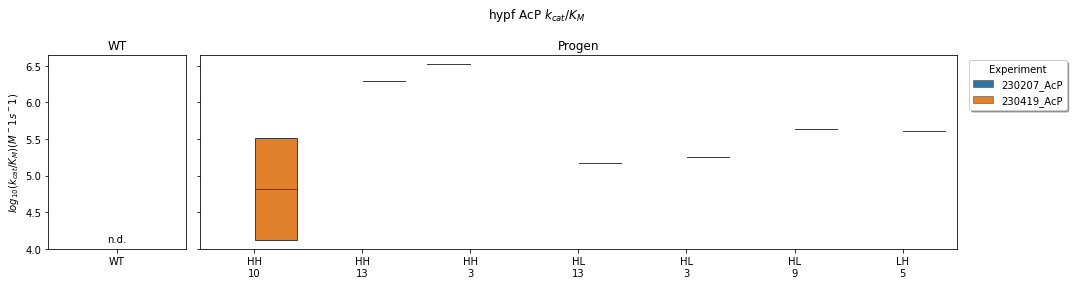

In [158]:
import matplotlib.pyplot as plt

species = 'hypf'
substrate = 'AcP'
origin = 'progen'

# Get all data from selected_turnover_dfs
dat = pd.DataFrame()

# select only the turnover dfs that have the substrate in the key
experiments_to_select = [
                        #  '221201_AcP',
                         '230207_AcP', 
                         '230410_AcP', 
                         '230419_AcP', 
                        #  '230612_AcP', 
                        #  '230622_AcP', 
                         '230629_AcP', 

                         '230419_ATP', 
                         '230612_ATP',
                         '230622_ATP', 

                         '230419_PEP', 
                         '230612_PEP'
                   ]
selected_turnover_dfs = {key: all_turnover_dfs[key] for key in all_turnover_dfs.keys() if substrate in key and key in experiments_to_select}

# for each experiment df in selected_turnover_dfs
for key in selected_turnover_dfs.keys():
    # only add the df to dat if the substrate is in the key
    if substrate in key:
        indices = selected_turnover_dfs[key]['Indices'].unique()
        unique_df = selected_turnover_dfs[key][selected_turnover_dfs[key]['Indices'].isin(indices)]
        unique_df['experiment'] = key
        dat = pd.concat([dat, unique_df])

# remove low local bg mutants from dat
dat = dat[dat['local_bg_ratio'] > 2]

# filter for high R2 mutants
dat = dat[dat['kcat_over_KM_fit_R2'] > 0.9]

# filter low enzyme concentration mutants
dat = dat[dat['EnzymeConc'] > 0.5]

# add 220405 data to dat
if species == 'hsapiens':  
    dat = pd.concat([dat, df_processed_220405_AcP])


# add literature values to dat
lit_dat = lit_df[lit_df['Substrate_abbrev'] == substrate]
lit_dat = lit_dat[lit_dat['Isoform'] == 'ACYP2']
lit_dat = lit_dat[lit_dat['Species'] == 'H. sapiens']
lit_dat = lit_dat[lit_dat['Mutation'] == 'WT']
lit_dat = lit_dat[lit_dat['Activity Measurement Reference'] == '(Paoli et al., 1997)']
lit_dat = lit_dat.rename(columns={'log10 kcat/KM (s-1 M-1)': 'kcat_over_KM_fit'})
lit_dat['experiment'] = 'lit.'
lit_dat['origin'] = 'WT'
lit_dat['species'] = 'hsapiens'
lit_dat['substrate'] = substrate
dat = pd.concat([dat, lit_dat])


# filter for desired substrate and species
dat = dat[dat['substrate'] == substrate]
dat = dat[dat['species'] == species]


# Create a figure with four subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'width_ratios': [2, 11]}, sharey=True)

# In the first subplot, plot a bar chart of the WT sequence kcat_over_KM_fit values for each experiment
if 'WT' in dat['origin'].unique():
    sns.boxplot(x='experiment', y='kcat_over_KM_fit', data=dat[dat['origin'] == 'WT'], ax=axs[0], linewidth=0.6)
    axs[0].set_title('WT')
    axs[0].set_ylabel('$log_{10}(k_{cat}/K_M) (M^-1 s^-1)$')
else:
    # annotate the plot to indicate that there is no WT data right above the x axis
    axs[0].annotate('n.d.', xy=(0.5, 0.05), xycoords='axes fraction', ha='center', va='center')
    axs[0].set_title('WT')
    axs[0].set_ylabel('$log_{10}(k_{cat}/K_M) (M^-1 s^-1)$')

    # set single tick to indicate that there is no WT data
    axs[0].set_xticks([0.5])
    axs[0].set_xticklabels(['WT'])
    

# Get the sorted order of the mutants
if origin == 'mutant':
    mutants = dat[dat['origin'] == 'mutant']['mutation'].unique()
    sorted_order = sorted(mutants, key=lambda x: x[1:-2])

    # use the sorted order to sort the dat df
    dat_sorted = dat.copy()
    dat_sorted['mutation'] = pd.Categorical(dat_sorted['mutation'], categories=sorted_order, ordered=True)
else:
    mutants = dat[dat['origin'] == origin]['design_rep'].unique()
    sorted_order = sorted(mutants)

    # use the sorted order to sort the dat df
    dat_sorted = dat.copy()
    dat_sorted['design_rep'] = pd.Categorical(dat_sorted['design_rep'], categories=sorted_order, ordered=True)

# In the second subplot, plot a bar chart of the progen sequence kcat_over_KM_fit values, and dodge by experiment, sorting the mutants by the sorted_order
dat_p = dat_sorted[dat_sorted['origin'] == origin]
if 'limit' in dat_p.columns:
    dat_p['color'] = np.where(dat_p['limit'] == 'lower', '#CCCCCC', 'blue')
    sns.boxplot(x='design_rep', y='kcat_over_KM_fit', data=dat_p, ax=axs[1], order=sorted_order, hue='experiment', dodge=True, linewidth=1)
axs[1].set_title(origin.capitalize())
axs[1].set_ylabel('')
axs[1].set_xlabel('')
# axs[1].set_ylim(1, 5)

# legend for second subplot
axs[-1].legend(loc='upper left', bbox_to_anchor=(1.01, 1), fancybox=True, shadow=True, ncol=1, title='Experiment')

# add super title to the figure
fig.suptitle(' '.join([species, substrate, '$k_{cat}/K_M$']))

# tight layout
plt.tight_layout()

# make export path
plot_export_path = figure_export_path + '/Catalysis/aggregated_expts/per_sequence_comparison/' + species + '/' + substrate + '/'

# # make export path if it doesn't exist
# if not os.path.exists(os.path.dirname(plot_export_path)):
#     os.makedirs(os.path.dirname(plot_export_path))

# # save images
# plt.savefig(plot_export_path + species + '_' + substrate + '_' + origin + '_kcat_over_KM_aggregated_expts.png', dpi=300, bbox_inches='tight')
# plt.savefig(plot_export_path + species + '_' + substrate + '_' + origin + '_kcat_over_KM_aggregated_expts.svg', bbox_inches='tight')

# Show the plot
plt.show()

k_obs boxplot

In [ ]:
import matplotlib.pyplot as plt

species = 'phorikoshii'
substrate = 'ATP'
origin = 'progen'

# Get all data from selected_turnover_dfs
dat = pd.DataFrame()

# select only the turnover dfs that have the substrate in the key
experiments_to_select = [
                        '221022_AcP',
                        '221201_AcP',
                        '230207_AcP', 
                        '230410_AcP', 
                        '230419_AcP', 
                        '230612_AcP', 
                    #  '230622_AcP', 
                        '230629_AcP', 
                        
                        '230419_ATP', 
                        '230612_ATP',
                        '230622_ATP', 
                        '230629_ATP',
                        
                        '230419_PEP', 
                        '230612_PEP'
                   ]
selected_turnover_dfs = {key: all_turnover_dfs[key] for key in all_turnover_dfs.keys() if substrate in key and key in experiments_to_select}

# for each experiment df in selected_turnover_dfs
for key in selected_turnover_dfs.keys():
    # only add the df to dat if the substrate is in the key
    if substrate in key:
        indices = selected_turnover_dfs[key]['Indices'].unique()
        unique_df = selected_turnover_dfs[key][selected_turnover_dfs[key]['Indices'].isin(indices)]
        unique_df['experiment'] = key
        dat = pd.concat([dat, unique_df])

# add 220405 data to dat
if species == 'hsapiens':  
    dat = pd.concat([dat, df_processed_220405_AcP])

    # replace underscores with \n in the design_rep column
    dat['experiment'] = dat['experiment'].apply(lambda x: x.replace('_', '\n'))

# add literature values to dat
lit_dat = lit_df[lit_df['Substrate_abbrev'] == substrate]
lit_dat = lit_dat[lit_dat['Isoform'] == 'ACYP2']
lit_dat = lit_dat[lit_dat['Species'] == 'H. sapiens']
lit_dat = lit_dat[lit_dat['Mutation'] == 'WT']
lit_dat = lit_dat[lit_dat['Activity Measurement Reference'] == '(Paoli et al., 1997)']
lit_dat = lit_dat.rename(columns={'log10 kcat/KM (s-1 M-1)': 'kcat_over_KM_fit'})
lit_dat['experiment'] = 'lit.'
lit_dat['origin'] = 'WT'
lit_dat['species'] = 'hsapiens'
lit_dat['substrate'] = 'AcP'
dat = pd.concat([dat, lit_dat])

# filter for desired substrate and species
dat = dat[dat['substrate'] == substrate]
dat = dat[dat['species'] == species]

# remove local bg ratio below 2
dat = dat[dat['local_bg_ratio'] >= 2]

# remove low R2 kobs fits
dat = dat[dat['Rsq_kobs'] >= 0.96]

# Create a figure with four subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw={'width_ratios': [2, 11]}, sharey=True)

# In the first subplot, plot a bar chart of the WT sequence kcat_over_KM_fit values for each experiment
if 'WT' in dat['origin'].unique():
    sns.boxplot(x='experiment', y='kobs_over_enzyme_conc', data=dat[dat['origin'] == 'WT'], ax=axs[0])
    axs[0].set_title('WT')
    axs[0].set_ylabel('$k_obs$ (s^-1)')
else:
    # annotate the plot to indicate that there is no WT data right above the x axis
    axs[0].annotate('n.d.', xy=(0.5, 0.05), xycoords='axes fraction', ha='center', va='center')
    axs[0].set_title('WT')
    axs[0].set_ylabel('$k_obs$ (s^-1)')

    # set single tick to indicate that there is no WT data
    axs[0].set_xticks([0.5])
    axs[0].set_xticklabels(['WT'])

# Get the sorted order of the mutants
if origin == 'mutant':
    mutants = dat[dat['origin'] == 'mutant']['mutation'].unique()
    sorted_order = sorted(mutants, key=lambda x: x[1:-1])
else:
    mutants = dat[dat['origin'] == origin]['design_rep'].unique()
    sorted_order = sorted(mutants)

# sort the data by the 'kcat_over_KM_fit' column
dat_sorted = dat.sort_values('kobs_over_enzyme_conc')

# In the second subplot, plot a bar chart of the progen sequence kcat_over_KM_fit values, and dodge by experiment, sorting the mutants by the sorted_order
dat_p = dat_sorted[dat_sorted['origin'] == origin]
if 'limit' in dat_p.columns:
    dat_p['color'] = np.where(dat_p['limit'] == 'lower', '#CCCCCC', 'blue')
    sns.boxplot(x='design_rep', y='kobs_over_enzyme_conc', data=dat_p, ax=axs[1], order=sorted_order, hue='experiment', dodge=True)
axs[1].set_title(origin.capitalize())
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_ylim(0, 0.00005)

# # set y scale as log
# axs[1].set_yscale('log')

# legend for second subplot
axs[-1].legend(loc='upper left', bbox_to_anchor=(1.01, 1), fancybox=True, shadow=True, ncol=1, title='Experiment')

# add super title to the figure
fig.suptitle(' '.join([species, substrate, '$k_{obs}$']), fontsize=16)

# tight layout
plt.tight_layout()

# make export path
plot_export_path = figure_export_path + '/Catalysis/aggregated_expts/per_sequence_comparison/' + species + '/' + substrate + '/'

# # make export path if it doesn't exist
# if not os.path.exists(os.path.dirname(plot_export_path)):
#     os.makedirs(os.path.dirname(plot_export_path))

# # save images
# plt.savefig(plot_export_path + species + '_' + substrate + '_' + origin + '_kcat_over_KM_aggregated_expts.png', dpi=300, bbox_inches='tight')
# plt.savefig(plot_export_path + species + '_' + substrate + '_' + origin + '_kcat_over_KM_aggregated_expts.svg', bbox_inches='tight')

# Show the plot
plt.show()

Plot facetgrid to compare sequence ID and lambda

In [ ]:
def plot_box_whisker_kcatKM_by_ID_lambda(all_turnover_dfs, substrate, species):
    dat = pd.DataFrame()
    for key in all_turnover_dfs.keys():
        if substrate in key:
            # unique indices in current df
            indices = all_turnover_dfs[key]['Indices'].unique()
            unique_df = all_turnover_dfs[key][all_turnover_dfs[key]['Indices'].isin(indices)]
            unique_df['experiment'] = key
            dat = pd.concat([dat, unique_df])

    # create column for design replicate where name ends in integer
    dat['design_rep'] = dat['name'].apply(lambda x: x.split('_')[-1])

    # remove non-progen sequences
    dat = dat[dat['origin'] == 'progen']

    # remove all but human
    dat = dat[dat['species'] == species]

    # set axes style to white
    sns.set_theme(style="ticks")

    # define color palette
    if species == 'phorikoshii':
        color_palette = 'Reds'
    elif species == 'sbenthica':
        color_palette = 'Blues'
    elif species == 'hsapiens':
        color_palette = 'Greens'
    else:
        color_palette = 'colorblind'

    # make separate columns for each origin value and sort columns and rows
    g = sns.FacetGrid(dat, col='lambda', row='seq_id', sharey=True, sharex=False, height=3.5, aspect=1, col_order=['high', 'low'], row_order=['high', 'low'])
    g.map_dataframe(sns.boxplot, x='design_rep', y='EnzymeConc', palette=color_palette, showfliers=False)

    # add labels
    g.set_axis_labels('Design Replicate', 'k_{cat}/K_M (uM^-1 s^-1)')
    g.set_xticklabels(rotation=45)

    # add title
    plt.suptitle(substrate + ' $k_{cat}/K_M$' + '\n' + 'Aggregated Expts: ' + str(set(dat['experiment'])), y=1.05)

    # set facecolor to white
    g.fig.set_facecolor('white')

    plt.tight_layout()
    
    # save as svg
    plot_export_path = figure_export_path + '/catalysis/aggregated_expts/'

    if not os.path.exists(os.path.dirname(plot_export_path)):
        os.makedirs(os.path.dirname(plot_export_path))

    plt.savefig(plot_export_path + substrate + f'_lambda_seqid_aggregated_expts_{substrate}_{species}.svg', dpi=300, bbox_inches='tight')
    
    plt.show()

    return dat

# plot each
plotted_df = plot_box_whisker_kcatKM_by_ID_lambda(all_turnover_dfs, 'AcP', 'hsapiens')

## Plot kcat/KM for ATP

Compare AcP and ATP hydrolysis

In [ ]:
def get_foldchange_df(sub1_medians, sub2_medians, ordered_substrates, manual_WT_rates=None):

    # merge ATP and AcP medians
    kcatKM_two_substrate_medians = pd.merge(sub1_medians, sub2_medians, on=['name', 'species', 'origin', 'ensemble_ll', 'predicted_tm'], suffixes=(f'_{ordered_substrates[0]}', f'_{ordered_substrates[1]}'))

    # get WT rates for each species
    species = list(set(kcatKM_two_substrate_medians['species']))
    WT_rates = dict(zip(ordered_substrates, [{} for i in ordered_substrates]))

    # get fold change in rate for each species
    combined_df = kcatKM_two_substrate_medians

    # get WT rates for each species
    for i in ordered_substrates:
        for j in species:
            species_rates = kcatKM_two_substrate_medians[kcatKM_two_substrate_medians['species'] == j]
            if len(species_rates[species_rates['name'].str.contains('wt', case=False)]) > 0:
                WT_rates[i][j] = species_rates[species_rates['name'].str.contains('wt', case=False)][f'kcat_over_KM_fit_median_{i}'].values[0]
    
    # create manual WT rates if necessary
    if manual_WT_rates != None:
        for key, value in manual_WT_rates.items():
            WT_rates[key] = value

    # calculate fold changes
    for i in ordered_substrates:
        for j in WT_rates[i].keys():
            for index, row in combined_df.iterrows():
                if row['species'] == j:
                    combined_df.loc[index, f'foldchange_{i}'] = np.log2(row[f'kcat_over_KM_fit_median_{i}'] / WT_rates[i][j])
                else:
                    pass

    print(WT_rates)

    return combined_df


In [ ]:
# All medians
AcP_medians = turnover_median_dfs['AcP']
ATP_medians = turnover_median_dfs['ATP']
PEP_medians = turnover_median_dfs['PEP']
ATP_medians[ATP_medians['origin'] == 'WT']

In [ ]:
# define manual WT rates
manual_WT_rates = {'AcP': {'hsapiens': 3, 'sbenthica': 1, 'phorikoshii':1},
                   'ATP': {'hsapiens': 1, 'sbenthica': 1, 'phorikoshii':1},
                   }

In [ ]:
df_foldchange_AcP_PEP = get_foldchange_df(AcP_medians, PEP_medians, ordered_substrates=['AcP', 'PEP'], manual_WT_rates=None)
df_foldchange_AcP_ATP = get_foldchange_df(AcP_medians, ATP_medians, ordered_substrates=['AcP', 'ATP'], manual_WT_rates=None)
df_foldchange_AcP_PEP

Plot fold change in kcat/KM for each substrate from WT

In [ ]:
import seaborn as sns

# initialize figure
num_subplots = 3
fig, axs = plt.subplots(1, num_subplots, figsize=(num_subplots*6, 6), sharex=True, sharey=True)

def plot_foldchange(df, species, substrates_xy, ax):
    # create color palette
    origin_list = ['pross', 'progen', 'WT', 'mutant']
    palette = sns.color_palette('colorblind', len(origin_list))
    palette_dict = dict(zip(origin_list, palette))

    # plot scatter of fold change in rate in seaborn
    sns.scatterplot(data=df, x='foldchange_%s' % substrates_xy[0], y='foldchange_%s' % substrates_xy[1], 
                    hue='origin', palette=palette_dict, ax=ax, s=150)
    
    # make x and y limits equal
    min_x, max_x = ax.get_xlim()
    min_y, max_y = ax.get_ylim()
    ax.set_xlim(min(min_x, min_y), max(max_x, max_y))

    # add lines at x and y = 0
    ax.axhline(0, color='black', linestyle='-')
    ax.axvline(0, color='black', linestyle='-')

    # add axis labels
    ax.set_xlabel('log2($k_{cat}/K_M$ fold change from WT in %s)' % substrates_xy[0])
    ax.set_ylabel('log2($k_{cat}/K_M$ fold change from WT in %s)' % substrates_xy[1])

    # sort legend alphabetically
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    by_label = {k: by_label[k] for k in sorted(by_label, reverse=True)}
    ax.legend(by_label.values(), by_label.keys(), fancybox=True, shadow=False, title='Origin', framealpha=0.8)

    # add title
    ax.set_title('%s \n $k_{cat}/K_M$ fold change from WT' % species)


## plot fold changes
species_list = ['phorikoshii', 'sbenthica', 'hsapiens']

for i, species in enumerate(species_list):
    # filter for only human variants
    dat = df_foldchange_AcP_ATP[df_foldchange_AcP_ATP['species'] == species]

    # make plots
    plot_foldchange(dat, species = species, substrates_xy=['AcP', 'ATP'],ax=axs[i])


# tight layout
plt.tight_layout()

Plot kcat/KM compared to WT with seaborn

In [ ]:
import seaborn as sns

# create a vertical histogram for kcat/KM, split by

## Plot Covariance Matrix

In [ ]:
from scipy.stats import entropy

# first, import the alignment
align = AlignIO.read("/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/Experiment_Aggregation/short_acyps_aligned.fasta", "fasta")
summary_align = AlignInfo.SummaryInfo(align)

In [ ]:
# get list of sequences from align object
seq_list = []
for record in align:
    seq_list.append(record.seq)

# convert each sequence to a list of characters
seq_list = [list(i) for i in seq_list]

# convert each character to a number
for i in seq_list:
    for j in range(len(i)):
        if i[j] == 'A':
            i[j] = 0
        elif i[j] == 'C':
            i[j] = 1
        elif i[j] == 'D':
            i[j] = 2
        elif i[j] == 'E':
            i[j] = 3
        elif i[j] == 'F':
            i[j] = 4
        elif i[j] == 'G':
            i[j] = 5
        elif i[j] == 'H':
            i[j] = 6
        elif i[j] == 'I':
            i[j] = 7
        elif i[j] == 'K':
            i[j] = 8
        elif i[j] == 'L':
            i[j] = 9
        elif i[j] == 'M':
            i[j] = 10
        elif i[j] == 'N':
            i[j] = 11
        elif i[j] == 'P':
            i[j] = 12
        elif i[j] == 'Q':
            i[j] = 13
        elif i[j] == 'R':
            i[j] = 14
        elif i[j] == 'S':
            i[j] = 15
        elif i[j] == 'T':
            i[j] = 16
        elif i[j] == 'V':
            i[j] = 17
        elif i[j] == 'W':
            i[j] = 18
        elif i[j] == 'Y':
            i[j] = 19
        else:
            i[j] = 20

De-gap the alignment

In [ ]:
# delete column if it contains more than 50% gaps
frames = np.asarray(seq_list)
frames = np.delete(frames, np.where((frames == 20).sum(axis=0) > 0.9*len(frames)), axis=1)

In [ ]:
covar = np.cov(frames, rowvar=False)

# increase figure size
plt.rcParams['figure.figsize'] = [7, 7]

# normalize covariance matrix
covar = covar / np.max(covar)

# shrink values below 0.6 to 0
covar[covar < 0.1] = 0

# plot covariance matrix as scatter plot
plt.imshow(covar, cmap='Reds', interpolation='nearest')

# # create colorbar and change normalization range
cbar = plt.colorbar()
# cbar.norm.vmax = 0.5

# add label to cbar
cbar.ax.set_ylabel('Normed Covariance', rotation=270, labelpad=15)

Format indices for data

In [ ]:
# define a regular expression to match numbers in the range 0-10
pattern = r"\{(0\d|\d),(0\d|\d)\}"

# The replacement string to use in the string replace operation
# It includes a leading zero for single-digit numbers and removes the curly brackets
replacement = r"0\1,0\2"

# Apply the string replace operation to each element in the column using the re.sub() function
for key in 

df_221201_SFL["Indices"] = df_221201_SFL["Indices"].apply(lambda x: re.sub(pattern, replacement, x))

In [ ]:

df_221022_SFL_merge['mutation'] = df_221022_SFL_merge.name.str.extract(r'([A-Z]\d{1,2}[A-Z])', expand=False)

# WT df
WT_df = df_221022_SFL_merge[df_221022_SFL_merge['origin'] == 'WT']

# add wt sequence to each row
df_221022_SFL_merge = pd.merge(df_221022_SFL_merge, WT_df[['species', 'protein_sequence']], on='species', suffixes=['', '_wt'])

For 230207, format names and merge sequence information with data

In [ ]:
# manual egfp culling
df_230207_SFL = df_230207_SFL[df_230207_SFL['egfp_manual_flag'] == False]

# merge the expression and full_sequence_library DataFrames
df_230207_SFL_merge = pd.merge(df_230207_SFL, full_protein_sequence_library, on=list(set(df_230207_SFL.columns).intersection(set(full_protein_sequence_library.columns))))
df_230207_SFL_merge = pd.merge(df_230207_SFL_merge, full_DNA_sequence_library, on=list(set(df_230207_SFL_merge.columns).intersection(set(full_DNA_sequence_library.columns))))
df_230207_SFL_merge = pd.merge(df_230207_SFL_merge, single_mutant_likelihoods, on=['mutation', 'protein_sequence'], how='outer')
df_230207_SFL_merge = df_230207_SFL_merge.fillna('')

# remove redundant rows for each chamber
df_230207_SFL_merge = df_230207_SFL_merge.drop_duplicates(subset='Indices')


In [ ]:
df_230207_SFL_merge

For 220608, format names and merge sequence information with data

In [ ]:
# manual egfp culling
df_220608_single_muts = df_220608_single_muts[df_220608_single_muts['ManualGFPFlag'] == 0]

# reduce to only a single row per chamber and add mutation column
df_220608_single_muts_merge = df_220608_single_muts[df_220608_single_muts['SubstrateConc'] == 10][['Indices', 'MutantID', 'fit_mm_kcatoverKM_MMfit', 'EnzymeConc', 'LocalBackgroundRatio']]

# add mutation column
df_220608_single_muts_merge['mutation'] = df_220608_single_muts_merge.MutantID.str.extract(r'([A-Z]\d{0,2}[A-Z])', expand=False).fillna('')

## Expression

### Experiment summaries

In [ ]:
def plot_pie_chart(series, title=None, ax=None):
    expression_outcomes = list(series.to_dict().keys())
    data = list(series.to_dict().values())

    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-10, colors=['goldenrod', 'darkslateblue'])

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    ax.set_title(title)

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(expression_outcomes[i] + '\n' + str(data[i]) + ' chambers', xy=(x, y), xytext=(1.01*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
                

In [ ]:
all_blanks

In [ ]:
import matplotlib.patheffects as PathEffects

fig, axs = plt.subplots(2, 4, figsize=(17,7), facecolor='white')

### 102222
# remove blank chambers
all_blanks = df_221022_SFL[df_221022_SFL['MutantID'] == 'BLANK'][[ "Indices", 'MutantID', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')
all_library = df_221022_SFL[df_221022_SFL['MutantID'] != 'BLANK'][[ "Indices", 'MutantID', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')

# plot histograms
axs[0, 0].hist(all_blanks['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='grey', alpha=0.3, edgecolor='black', label='Blank Chambers')
axs[0, 0].hist(all_library['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='orange', alpha=0.3, edgecolor='brown', label='Library Members')

# set plot labels
axs[0, 0].set_xlabel('eGFP Concentration (uM)')
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_ylabel('Count')
axs[0, 0].set_title('10/22/22 \n Expression')
# axs[0, 0].ticklabel_format(style='plain')

counts = df_221022_SFL_merge.drop_duplicates(subset='Indices')
counts = counts.assign(expression_outcome=['expressed' if x >= 5 else 'no expression' for x in counts['summed_button_BGsub_Button_Quant']])

s_pross = counts[counts['origin'] == 'pross']['expression_outcome'].value_counts()
s_progen = counts[counts['origin'] == 'progen']['expression_outcome'].value_counts()
s_WT = counts[counts['origin'] == 'WT']['expression_outcome'].value_counts()

plot_pie_chart(s_pross, title='PROSS', ax=axs[0, 1])
plot_pie_chart(s_progen, title='ProGen2', ax=axs[0, 2])
plot_pie_chart(s_WT, title='WT', ax=axs[0, 3])

### 230207
# remove blank chambers
all_blanks = df_230207_SFL[df_230207_SFL['MutantID'] == 'BLANK'][[ "Indices", 'MutantID', 'x', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')
all_library = df_230207_SFL[df_230207_SFL['MutantID'] != 'BLANK'][[ "Indices", 'MutantID', 'x', 'summed_button_BGsub_Button_Quant']].drop_duplicates(subset=['Indices'], keep='first')
all_blanks = all_blanks[all_blanks['x'] < 16]
all_library = all_library[all_library['x'] < 16]

# plot histograms
axs[1, 0].hist(all_blanks['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='grey', alpha=0.3, edgecolor='black', label='Blank Chambers')
axs[1, 0].hist(all_library['summed_button_BGsub_Button_Quant'], stacked=True, bins=30, facecolor='orange', alpha=0.3, edgecolor='brown', label='Library Members')

# set plot labels
axs[1, 0].set_xlabel('eGFP Concentration (uM)')
axs[1, 0].legend(loc='upper right')
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_title('02/07/23 \n Right Side Expression')
# axs[1, 0].ticklabel_format(style='plain')

counts = df_230207_SFL_merge.drop_duplicates(subset='Indices')
counts = counts.assign(expression_outcome=['expressed' if x >= 5 else 'no expression' for x in counts['summed_button_BGsub_Button_Quant']])

s_pross = counts[counts['origin'] == 'pross']['expression_outcome'].value_counts()
s_progen = counts[counts['origin'] == 'progen']['expression_outcome'].value_counts()
s_WT = counts[counts['origin'] == 'WT']['expression_outcome'].value_counts()

plot_pie_chart(s_pross, ax=axs[1, 1])
plot_pie_chart(s_progen, ax=axs[1, 2])
plot_pie_chart(s_WT, ax=axs[1, 3])

axs[1, 1].set_title('PROSS')
axs[1, 2].set_title('ProGen2')
axs[1, 3].set_title('WT')

plt.tight_layout()


# define export directory
current_export_directory = figure_export_path + '/aggregated/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v3'
fig.savefig(current_export_directory + "summary_expression_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "summary_expression_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

## Scatter of expression vs number of mutations

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True, facecolor='white')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=3, hspace=None)

df_230207_SFL_merge.plot.scatter(x='n_mutations', y='EnzymeConc', ax=ax[0], alpha=0.4)
ax[0].set_xlabel('Number of Mutations \n Relative to WT')
ax[0].set_ylabel('Enzyme \n Concentration (nM)')
ax[0].set_title('230207 Expt')

df_221022_SFL_merge.drop_duplicates(subset='Indices').plot.scatter(x='n_mutations', y='EnzymeConc', ax=ax[1], alpha=0.4)
ax[1].set_xlabel('Number of Mutations \n Relative to WT')
ax[1].set_ylabel('')
ax[1].set_title('221022 Expt')


plt.tight_layout()


# define export directory
current_export_directory = figure_export_path + '/expression/sequence_identity/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v1'
plt.savefig(current_export_directory + 'n_mutations_vs_expression_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + 'n_mutations_vs_expression_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight') 

### Device Heatmap

In [ ]:
### 221022
# df_221022_SFL = df_221022_SFL[(df_221022_SFL['local_bg_ratio'] < 70) & (df_221022_SFL['local_bg_ratio'] > 0)]
lbg_ratio = df_221022_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['local_bg_ratio'].apply(list).reset_index(name='lbg_ratio')
substrate_concs = df_221022_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['substrate_conc_uM'].apply(list).reset_index(name='substrate_concs')
squeeze_mm_221022 = pd.merge(substrate_concs, lbg_ratio, on=['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])

squeeze_mm_221022['substrate_concs'] = squeeze_mm_221022['substrate_concs'].apply(lambda x: [0] + x) # insert zero at beginning of list
squeeze_mm_221022['lbg_ratio'] = squeeze_mm_221022['lbg_ratio'].apply(lambda x: x[1]) # insert zero at beginning of list

### 230207
# df_230207_SFL = df_230207_SFL[(df_230207_SFL['local_bg_ratio'] < 70) & (df_230207_SFL['local_bg_ratio'] > 0)]
lbg_ratio = df_230207_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['local_bg_ratio'].apply(list).reset_index(name='lbg_ratio')
substrate_concs = df_230207_SFL.groupby(['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])['substrate_conc_uM'].apply(list).reset_index(name='substrate_concs')
squeeze_mm_230207 = pd.merge(substrate_concs, lbg_ratio, on=['x', 'y', 'Indices', 'MutantID', 'EnzymeConc'])

squeeze_mm_230207['substrate_concs'] = squeeze_mm_230207['substrate_concs'].apply(lambda x: [0] + x) # insert zero at beginning of list
squeeze_mm_230207['lbg_ratio'] = squeeze_mm_230207['lbg_ratio'].apply(lambda x: x[1]) # insert zero at beginning of list

# now, save substrate concs
all_substrate_concs = squeeze_mm_230207['substrate_concs'][0]

squeeze_mm_230207

In [ ]:
def heatmap(data, ax=None, fig=None, norm=None, cmap=None, vmin=None, vcenter=None, vmax=None,
            cbar_kw=None, cbarlabel="", display_cbar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    # if ax is None:
    #     ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # create vcenter if None provided
    if vcenter == None:
        vcenter = (vmax - vmin)/2

    # PCM method
    divnorm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    pcm = ax.pcolormesh(data, cmap=cmap, norm=divnorm)

    # Create colorbar
    if display_cbar == True:
        cbar = fig.colorbar(pcm, ax=ax, norm=mpl.colors.Normalize(vmin=0, vmax=20), **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    else:
        cbar = None

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    ax.tick_params(which="minor", bottom=False, left=False)

    return pcm, cbar

In [ ]:
parameter = 'enzyme_conc'

fig, axs = plt.subplots(2,2, figsize=(10,12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=0.5)


### 221022
grid = squeeze_mm_221022.fillna(0)

# plot enz conc
grid_EC = grid.pivot('x', 'y', 'EnzymeConc')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="plasma", 
                    cbarlabel="Enzyme Conc (nM)", 
                    display_cbar=display_cbar,
                    ax=axs[0, 0],
                    vmin=0,
                    vmax=100,
                    fig=fig
                    )
axs[0, 0].set_xlabel("Column")
axs[0, 0].set_ylabel("Row")
axs[0, 0].set_title("10/22/22 Experiment")

# plot local BG ratio
grid_EC = grid.pivot('x', 'y', 'lbg_ratio')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="viridis", 
                    cbarlabel="Local Background Ratio", 
                    display_cbar=display_cbar,
                    ax=axs[0, 1],
                    vmin=0,
                    vcenter=2,
                    vmax=20,
                    fig=fig                    
                    )
axs[0, 1].set_xlabel("Column")
axs[0, 1].set_ylabel("Row")
axs[0, 1].set_title("10/22/22 Experiment")


### 230207
grid = squeeze_mm_230207.fillna(0)

# plot enz conc
grid_EC = grid.pivot('x', 'y', 'EnzymeConc')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="plasma", 
                    cbarlabel="Enzyme Conc (nM)", 
                    display_cbar=display_cbar,
                    ax=axs[1, 0],
                    vmin=0,
                    vmax=100,
                    fig=fig
                    )
axs[1, 0].set_xlabel("Column")
axs[1, 0].set_ylabel("Row")
axs[1, 0].set_title("02/07/23 Experiment")

# plot local BG ratio
grid_EC = grid.pivot('x', 'y', 'lbg_ratio')
grid_EC = np.flip(np.array(grid_EC).T, (0, 1))
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="viridis", 
                    cbarlabel="Local Background Ratio", 
                    display_cbar=display_cbar,
                    ax=axs[1, 1],
                    vmin=0,
                    vcenter=2,
                    vmax=20,
                    fig=fig
                    )
axs[1, 1].set_xlabel("Column")
axs[1, 1].set_ylabel("Row")
axs[1, 1].set_title("02/07/23 Experiment")

# define export directory
current_export_directory = figure_export_path + '/aggregated/' + parameter

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
plt.savefig(current_export_directory + '/heatmap_SFL_%s.png' % (version), bbox_inches = 'tight')
plt.savefig(current_export_directory + '/heatmap_SFL_%s.svg' % (version), bbox_inches = 'tight')

## kcat/KM by construct: box and whisker plot

Define lit and past expt's

In [ ]:
C21S = 14000
T42A = 12700

benzoyl_phosphate_pKa = 4.19
acetyl_phosphate_pKa = 4.75

lfer_slope = -1.4439572688424076


lit_vals_muts = {13: acetyl_phosphate_pKa*(T42A/benzoyl_phosphate_pKa), 3: acetyl_phosphate_pKa*(C21S/benzoyl_phosphate_pKa)}
expt_220405 = {13:10445.332, 3: 36072.06, 7: 11487.432, 11: 104298.180, 14: 30616.233}

In [ ]:
set(df_230207_SFL_merge.species)

In [ ]:
parameter = 'kcat_over_KM_fit'
species = 'consensus'
description = '$k_{cat}/K_M$ ($M^{-1} s^{-1}$)'
expt_date = '230207'
# description = 'designs'

expression_230207 = df_230207_SFL_merge[(df_230207_SFL_merge['species'] == species)]
expression_221022 = df_221022_SFL_merge[(df_221022_SFL_merge['species'] == species)]

box_df = globals()['expression_' + expt_date][['origin', 'sampling_replicate', 'species', parameter, 'lambda', 'seq_id', 'mutation', 'kinetic_limit']]

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + 0.1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index, level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    
def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    label_d = dict(zip(df.index.names[::-1], range(df.index.nlevels)[::-1]))
    for k, level in label_d.items():
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes) # add primary label
            ax.text(0, ypos, k + ':  ', ha='right', transform=ax.transAxes) # add level label to left
            # add_line(ax, pos*scale, ypos)

            # if the current level is the highest in the hierarchy, add additional lines 
            # to connect that level's dividers up to the x-axis line
            if level == 0:
                for i in label_d.values():
                    add_line(ax, pos * scale , ypos + i/10)
            else:
                add_line(ax, pos * scale , ypos)

            pos += rpos
        ypos -= 0.1



### FIRST PLOT
# box_df = box_df[(box_df['species'] == species) & (box_df['origin'] == 'progen') & (box_df['origin'] != 'pross')] 
df = box_df.groupby(['species', 'origin', 'lambda', 'seq_id', 'sampling_replicate', 'mutation'])
df_indices = box_df.groupby(['species', 'origin', 'lambda', 'seq_id', 'sampling_replicate', 'mutation']).median()
fig = plt.figure(figsize=(25, 15))

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)

ax = fig.add_subplot(111)

# plot
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=2, color='k')

df.boxplot(subplots=False, 
           ax=fig.gca(), 
           grid=False,
           boxprops=boxprops,
           medianprops=medianprops
           )

# plot points
for g_index, g_row in enumerate(df):
    for index, row in g_row[1].iterrows():
        y = row[parameter]
        x = [g_index+1]

        # plot non-limits
        if row['kinetic_limit'] == 'none':
            ax.plot(x, y, mec='k', ms=7, marker="o", linestyle="None")
        
        # plot limits
        elif row['kinetic_limit'] == 'upper':
            ax.plot(x, y, mec='k', ms=20, marker="x", linestyle="None")

# ax.plot(list(lit_vals_muts.keys()), list(lit_vals_muts.values()), marker='+', label='Literature', mec='k', ms=10, linestyle="None")
# ax.plot(list(expt_220405.keys()), list(expt_220405.values()), marker='^', label='220405 Expt', mec='k', ms=15, linestyle="None")
# ax.legend()

#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
ax.set_ylabel(description)
ax.set_yscale('log')
ax.set_title('  /  '.join([parameter, species, expt_date]), loc='left')

# hide zero y-axis label
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

label_group_bar_table(ax, df_indices)

fig.subplots_adjust(bottom = .1 * df_indices.index.nlevels)
fig.set_facecolor('white')

# define export directory
current_export_directory = figure_export_path + 'by_construct/' + expt_date + '/' + parameter

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

# version = 'v2'
# plt.savefig(current_export_directory + '/%s_%s_by_construct_%s_%s_%s.png' % (expt_date, parameter, species, description, version), dpi=300, transparent=False, bbox_inches='tight') 
# plt.savefig(current_export_directory + '/%s_%s_by_construct_%s_%s_%s.svg' % (expt_date, parameter, species, description, version), dpi=300, transparent=False, bbox_inches='tight') 

plt.show()

# Stability Data

First, process the data

In [ ]:
# filter by expression
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP[df_230207_SFL_DiFMUP['EnzymeConc'] > 2]

# filter for single row per chamber
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['local_bg_ratio_x'] > 2]

# filter for single row per chamber
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['urea_conc_mM'] == 0]

# filter no egfp flag
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['egfp_manual_flag'] == False]

# subset columns
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[['Indices', 'MutantID', 'EnzymeConc', 'two_point_fit', 'rate_fit_regime',
       'egfp_manual_flag', 'urea_concs',
       'initial_rates', 'later_rates', 'popt_initial', 'popt_later',
       'local_bg_ratio_x']]

# add species labels
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("sbenthica"), 'species'] = 'sbenthica'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("hsapiens2"), 'species'] = 'hsapiens'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("human"), 'species'] = 'hsapiens'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("phorikoshii"), 'species'] = 'phorikoshii'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("hypf"), 'species'] = 'hypf'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("\w\d{5,10}\w", regex=True), 'species'] = 'uncharacterized' # matchs the naming convention that Clara used to describe the uncharacterized bacterial ACYPs
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("consensus"), 'species'] = 'consensus'

# add mutant column
df_230207_SFL_DiFMUP_filtered['mutation'] = df_230207_SFL_DiFMUP_filtered.MutantID.str.extract(r'([A-Z]\d{1,2}[A-Z])', expand=False)
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("wt", regex=False), 'mutation'] = 'WT'

# add origin
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("[A-Z]\d{1,2}[A-Z]", regex=True), 'origin'] = 'mutant'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("wt", regex=False), 'origin'] = 'WT'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("pross"), 'origin'] = 'pross'
df_230207_SFL_DiFMUP_filtered.loc[df_230207_SFL_DiFMUP_filtered['MutantID'].str.contains("lambda"), 'origin'] = 'progen'

# fill nan
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered.fillna(np.nan).reset_index()


Next, initialize sigmoid curve function

In [ ]:
def sigmoid(x, m1, m2, m3):
    return m1/(1 + np.exp(-m2 * ((m3-x)/0.5921))) # 0.5921 is R*T
v_sigmoidal = np.vectorize(sigmoid)

Next, plot overlayed curves

In [ ]:
# init list
curr_list = [
             'WT', 
            'V9A',
            'R97A',
             ]

# create df
curr_df = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['mutation'].isin(curr_list)]
curr_df = curr_df[curr_df['EnzymeConc'] > 50]
curr_df = curr_df[curr_df['species'] == 'hsapiens']

# init fig
fig, axs = plt.subplots(1, 1, figsize=(7, 7), facecolor='white')

# color dict
color_dict = dict(zip(curr_list, range(len(curr_list))))

# init legend elements
legend_elements = []

# plot kcat/KM from MM fit
for index, row in curr_df.iterrows():
    EnzConc = float(row.EnzymeConc)
    mutation = row.mutation
    print(mutation, EnzConc)

    # normalize by enzyme concentration
    initial_rates = [i/EnzConc for i in ast.literal_eval(row.initial_rates)][2:]
    later_rates = [i/EnzConc for i in ast.literal_eval(row.later_rates)][2:]
    urea_concs = [i/1000 for i in ast.literal_eval(row.urea_concs)][2:]

    # format parameters
    if ',' in row.popt_later:
        popt_later = ast.literal_eval(row.popt_later)
        popt_later[0] = popt_later[0]
    else:
        popt_later = ast.literal_eval(row.popt_later.replace('  ', ',').replace(' ', ','))
        popt_later[0] = popt_later[0]

    # init linspace
    linx = np.linspace(0, 8, 300)

    # normalize 
    liny = v_sigmoidal(linx, *popt_later)
    later_rates = np.array(later_rates)/liny[0]
    liny = np.array(liny)/liny[0]

    # plot
    axs.scatter(x=urea_concs, y=later_rates, alpha=1, color='C'+str(color_dict[mutation]))
    axs.plot(linx, liny, color='C'+str(color_dict[mutation]))

for m in curr_list:
    # add handles
    legend_elements.append(Line2D([0], [0], marker='o', color='C'+str(color_dict[m]), label=m))

axs.legend(fancybox=True, shadow=True, handles=legend_elements)
axs.set_xlabel('Urea Concentration (M)')
axs.set_ylabel('Normalized Rate (RFU $s^{-1}$)')
axs.set_ylim(0, 1.1)

# define export directory
current_export_directory = figure_export_path + '/stability/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
fig.savefig(current_export_directory + "sample_unfolding_curve3_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "sample_unfolding_curves_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

Get m1, m2, m3 from popt lists in dataframe

In [ ]:
for index, row in df_230207_SFL_DiFMUP_filtered.iterrows():
    if ',' in row.popt_later:
        popt_later = ast.literal_eval(row.popt_later)
    else:
        popt_later = ast.literal_eval(row.popt_later.replace('  ', ',').replace(' ', ',').replace(',,', ',').replace('[,', '['))

    if ',' in row.popt_initial:
        popt_initial = ast.literal_eval(row.popt_initial)
    else:
        popt_initial = ast.literal_eval(row.popt_initial.replace('  ', ',').replace(' ', ',').replace(',,', ',').replace('[,', '['))

    # add later rates
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm1_later'] = popt_later[0]
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm2_later'] = popt_later[1]
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm3_later'] = popt_later[2]

    # add initial rates
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm1_initial'] = popt_initial[0]
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm2_initial'] = popt_initial[1]
    df_230207_SFL_DiFMUP_filtered.loc[index, 'm3_initial'] = popt_initial[2]


Filter data

In [ ]:
# remove negative Cm values
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['m3_initial'] > 0]

 Import lit Cm values

In [ ]:
Chiti_measurements = pd.read_excel('/Users/micaholivas/Desktop/Stanford/Research/Chiti_1999_hACYP2_stability_measurements.xlsx')

Chiti_measurements['Cm_mean'] = Chiti_measurements['Cm (M)'].str.split('±')
Chiti_measurements[['Cm_mean', 'Cm_error']] = pd.DataFrame(Chiti_measurements['Cm_mean'].tolist(), index=Chiti_measurements.index)

Chiti_measurements['Cm_mean'] = pd.to_numeric(Chiti_measurements['Cm_mean'], errors='coerce')
Chiti_measurements['Cm_error'] = pd.to_numeric(Chiti_measurements['Cm_error'], errors='coerce')
Chiti_measurements['mutation'] = Chiti_measurements['Mutant']
Chiti_measurements = Chiti_measurements.replace(to_replace=r'wild type', value='WT', regex=True)

# add additional columns
Chiti_measurements['comparison'] = 'literature'
Chiti_measurements['Cm (M)'] = Chiti_measurements['Cm_mean']
Chiti_measurements = Chiti_measurements[['mutation', 'Cm (M)', 'comparison', 'Cm_error', 'm value']]
Chiti_measurements

Next, compare Cm from later rate fit and initial rate fit

In [ ]:
# filter for human WT and single substitution mutants
dat = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['species'] == 'hsapiens']
dat = dat[(dat['origin'] == 'mutant') | (dat['origin'] == 'WT')]
dat['Cm (M)'] = dat['m3_initial']
dat['comparison'] = 'experimental'

# Use the sorted groups to plot the boxplot
fig, axs = plt.subplots(1, 1, figsize=(6, 6), facecolor='white', sharey=True)

sorted_groups = dat.groupby('mutation')['Cm (M)'].median().sort_values().index

sns.boxplot(x='mutation', y='Cm (M)', data=dat, ax=axs, order=sorted_groups, width=0.5, linewidth=2, dodge=False, color='skyblue')
sns.stripplot(x='mutation', y='Cm (M)', data=Chiti_measurements, ax=axs, order=sorted_groups, color='orange', size=5, jitter=False, marker='s', linewidth=1, edgecolor='black')

axs.set_ylim(0, 8)
axs.set_ylabel('$C_m$ (M)')
axs.set_xlabel('Mutant (sorted by Median Experimental $C_m$)')
axs.set_title('Human substitution mutant Cm\'s')

handles = [plt.Rectangle((0, 0), 1, 1, color='skyblue', label='HT-MEK 230207'),
           plt.Rectangle((0, 0), 1, 1, color='orange', label='Chiti et al. 1999', edgecolor='black')]
axs.legend(title='Source', fancybox=True, shadow=True, handles=handles)

# rotate x labels
for item in axs.get_xticklabels():
    item.set_rotation(45)

# define export directory
current_export_directory = figure_export_path + '/stability/literature_mutants/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
fig.savefig(current_export_directory + "hACYP2_single_mutant_stability_measurements_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "hACYP2_single_mutant_stability_measurements_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
lit_comparison = pd.merge(Chiti_measurements[['mutation', 'Cm (M)', 'm value']], df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered['species'] == 'hsapiens'][['mutation', 'm3_initial', 'm2_initial']], on='mutation', suffixes=['Chiti', '230207'])

lit_comparison.sort_values('Cm (M)')
lit_comparison.columns = ['mutation', 'lit. Cm (M)', 'lit. m value', 'Measured Cm (M)', 'Measured m value']
lit_comparison['Measured m value'] = lit_comparison['Measured m value'] * 4.184 # conversion from cal to J; Fanny's gas constant was in kcal mol-1 K-1
lit_comparison

Plot lit vs expt medians

In [ ]:
import scipy
from sklearn.metrics import r2_score

fig, axs = plt.subplots(1, 3, figsize=(12, 8), facecolor='white')

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[df_230207_SFL_DiFMUP_filtered.m3_initial.round(3) != 3.470] # remove bad fit Y25A
df_230207_SFL_DiFMUP_filtered = df_230207_SFL_DiFMUP_filtered[(df_230207_SFL_DiFMUP_filtered['m2_initial'] < 6) & df_230207_SFL_DiFMUP_filtered['m2_initial'] > 0] # remove bad fits
stability_meds = df_230207_SFL_DiFMUP_filtered.groupby('mutation', as_index=False).agg(Cm_230207_median=('m3_initial', 'median'), Cm_230207_std=('m3_initial', 'std'), m_value_230207_median=('m2_initial', 'median'))
stability_meds['m_value_230207_median'] = stability_meds['m_value_230207_median'] * 4.184
lit_comparison_meds = pd.merge(Chiti_measurements[['mutation', 'Cm (M)', 'm value']], stability_meds[['mutation', 'Cm_230207_median', 'm_value_230207_median']], on='mutation', suffixes=['_Chiti', '230207_'])


# PLOT Cm's
# fit line of best fit with slope constrained to 1
def lin(x, b):
    return x + b

popt, pcov = scipy.optimize.curve_fit(f=lin, xdata=lit_comparison.dropna()['lit. Cm (M)'], ydata=lit_comparison.dropna()['Measured Cm (M)'])

# calculate R_sq
y_fit = lit_comparison.dropna()['lit. Cm (M)'] + popt
y_actual = lit_comparison.dropna()['Measured Cm (M)']
R_sq = r2_score(y_actual, y_fit)

linx = np.linspace(0, 7, 3)
axs[0].scatter(lit_comparison_meds['Cm (M)'], lit_comparison_meds['Cm_230207_median'], c='k')
axs[0].plot([2,7], [2,7], 'b--', alpha=0.5, label='Identity Line')
axs[0].plot(linx, linx + popt[0], 'k-', label='R_sq: %s' % round(R_sq, 2))
axs[0].set_xlabel('$C_m$, lit. (28°C)')
axs[0].set_ylabel('$C_m$, expt. (20.5°C)')
axs[0].set_xlim(2, 7)
axs[0].set_ylim(3, 8)
axs[0].legend(fancybox=True, shadow=True, loc='lower right')
axs[0].set_box_aspect(1)
axs[0].set_title('$C_m$ Comparison')
plt.tight_layout()

# annotate WT point
annotate_df = lit_comparison_meds[lit_comparison_meds['mutation'] == 'WT']
for index, row in annotate_df.iterrows():
    axs[0].annotate(text=row['mutation'], xy=(row['Cm (M)'], row['Cm_230207_median']),
                xytext=(0, 20), textcoords='offset points', fontsize=14, color='darkslategrey',
                arrowprops=dict(arrowstyle="-", color='darkslategrey', lw=2),
                ha='center', va='bottom')
    

# PLOT m-values
# fit line of best fit with slope constrained to 1
def lin(x, b):
    return x + b

popt, pcov = scipy.optimize.curve_fit(f=lin, xdata=lit_comparison.dropna()['lit. m value'], ydata=lit_comparison.dropna()['Measured m value'])

# calculate R_sq
y_fit = lit_comparison.dropna()['lit. m value'] + popt
y_actual = lit_comparison.dropna()['Measured m value']
R_sq = r2_score(y_actual, y_fit)

linx = np.linspace(min(lit_comparison.dropna()['lit. m value']), max(lit_comparison.dropna()['lit. m value']), 3)
axs[1].scatter(lit_comparison_meds['m value'], lit_comparison_meds['m_value_230207_median'], c='k')
axs[1].plot([2,7], [2,7], 'b--', alpha=0.5, label='Identity Line')
axs[1].plot(linx, linx + popt[0], 'k-', label='R_sq: %s' % round(R_sq, 2))
axs[1].set_xlabel('m value, lit. (28°C)')
axs[1].set_ylabel('m value, HT-MES$^{cat}$ (20.5°C)')
axs[1].set_xlim(3, 7)
axs[1].set_ylim(2, 6)
axs[1].set_box_aspect(1)
axs[1].set_title('m value')
plt.tight_layout()

# annotate WT point
annotate_df = lit_comparison_meds[lit_comparison_meds['mutation'] == 'WT']
for index, row in annotate_df.iterrows():
    axs[1].annotate(text=row['mutation'], xy=(row['m value'], row['m_value_230207_median']),
                xytext=(20, 0), textcoords='offset points', fontsize=14, color='k',
                arrowprops=dict(arrowstyle="-", color='darkslategrey', lw=2),
                ha='center', va='bottom')
    

# PLOT Cm vs m value
# linx = np.linspace(min(lit_comparison.dropna()['lit. m value']), max(lit_comparison.dropna()['lit. m value']), 3)
axs[2].scatter(lit_comparison_meds['Cm_230207_median'], lit_comparison_meds['m_value_230207_median'], c='k')
axs[2].set_xlabel('Cm, HTME$^{cat}$')
axs[2].set_ylabel('m value, HTMES$^{cat}$')
axs[2].set_box_aspect(1)
axs[2].set_title('$C_m$ vs m value')
axs[2].legend(fancybox=True)
plt.tight_layout()

    
# define export directory
current_export_directory = figure_export_path + '/Stability/iterature_comparison/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = ''
fig.savefig(current_export_directory + "summary_stability_lit_comparison_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')
fig.savefig(current_export_directory + "summary_stability_lit_comparison_%s.svg" % version, dpi=300, transparent=False, bbox_inches='tight')

### Get highest Cm values for each species

In [ ]:
dat = df_230207_SFL_DiFMUP_filtered[['MutantID', 'species', 'm3_initial', 'origin']]

# filter for hsapiens and progen
dat = dat[dat['species'] == 'hsapiens']
dat = dat[dat['origin'] == 'progen']

dat.sort_values(by='m3_initial', inplace=True, ascending=False)

dat.head(10)


# Plot kcat/KM and Cm against ensemble log-likelihood

AcP kcat/KM vs ensemble log-likelihood

In [ ]:
# import patch
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# import scipy
import scipy

In [ ]:

# init figure
fig, axs = plt.subplots(facecolor='white', figsize=(7, 7))

# define species_color_dict  
species_color_dict = {'sbenthica':'blue', 'hsapiens':'k', 'phorikoshii':'red', 'hypf':'green', 'consensus':'purple'}

# define markers
# markers = {'upper': '$\downarrow$', 'none': 'o'}
markers = {'WT' : '^', 'progen': 'o', 'pross': 'x', 'consensus': '*'}

# filter data
dat = turnover_median_dfs['AcP']
dat = dat[dat['species'] != 'uncharacterized']
dat = dat[dat['species'] != 'hypf']

# remove points if std deviation is too high
dat = dat[dat['kcat_over_KM_fit_std'] < 0.3]

# plot kcat/KM against ELL
for index, row in dat.iterrows():
    axs.errorbar(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], 
                 yerr=row['kcat_over_KM_fit_std'],
                 color='gray', alpha=0.5, fmt=' ', zorder=0)
    axs.scatter(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], color=species_color_dict[row['species']], 
                s=50, alpha=0.5, marker=markers[row['origin']])
axs.set_xlabel('ProGen2 \n ensemble log-likelihood')
axs.set_ylabel('$log(k_{cat}/K_M)$ ($M^{-1} s^{-1}$)')
axs.legend(fancybox=True, shadow=True)

# plot line of best fit
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=dat['ensemble_ll'], y=dat['kcat_over_KM_fit_median'])
linx = np.linspace(min(dat['ensemble_ll']), max(dat['ensemble_ll']), 3)
axs.plot(linx, intercept + slope*linx, 'k-', label='R_sq: %s' % round(r_value**2, 2))


# Manually add patches to legend, including markers
legend_elements = [
                   mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
                   mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
                   mpatches.Patch(facecolor=species_color_dict['sbenthica'], label='S. benthica'),
                   Line2D([0], [0], marker='x', markeredgecolor='k', label='PROSS', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='o', markeredgecolor='k', label='Progen', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='^', markeredgecolor='k', label='WT', linestyle='None', markersize=10, markerfacecolor='k'),
                #    Line2D([0], [0], marker='*', markeredgecolor=species_color_dict['consensus'], label='Consensus', linestyle='None', markersize=10, markerfacecolor=species_color_dict['consensus']),
                   Line2D([0], [0], marker='', color='k', label='$R^2$: %s' % round(r_value**2, 3), linestyle='-', markersize=10, markerfacecolor='k'),
                   ]

axs.legend(handles=legend_elements, fancybox=True, shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# export figure
current_export_directory = figure_export_path + '/ELL_comparisons/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v6'
fig.savefig(current_export_directory + "kcat_over_KM_ELL_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')

Do the above for human and phorikoshii alone

In [ ]:
selected_species = 'phorikoshii'
# init figure
fig, axs = plt.subplots(facecolor='white', figsize=(4, 4))

# define species_color_dict  
species_color_dict = {'sbenthica':'blue', 'hsapiens':'k', 'phorikoshii':'red', 'hypf':'green', 'consensus':'purple'}

# define markers
# markers = {'upper': '$\downarrow$', 'none': 'o'}
markers = {'WT' : '^', 'progen': 'o', 'pross': 'x', 'consensus': '*'}

# filter data
dat = turnover_median_dfs['AcP']
dat = dat[dat['kcat_over_KM_fit_std'] < 0.3]
dat = dat[dat['species'] == selected_species]
          
# plot kcat/KM against ELL
for index, row in dat.iterrows():
    axs.errorbar(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], 
                 yerr=row['kcat_over_KM_fit_std'],
                 color='gray', alpha=0.5, fmt=' ', zorder=0)
    axs.scatter(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], color=species_color_dict[row['species']], 
                s=50, alpha=0.5, marker=markers[row['origin']])
axs.set_xlabel('ProGen2 \n ensemble log-likelihood')
axs.set_ylabel('$log(k_{cat}/K_M)$ ($M^{-1} s^{-1}$)')
axs.set_title('P. horikoshii')

# export figure
current_export_directory = figure_export_path + '/ELL_comparisons/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v6'
fig.savefig(current_export_directory + f"kcat_over_KM_ELL_{selected_species}_{version}.png", dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
selected_species = 'hsapiens'
# init figure
fig, axs = plt.subplots(facecolor='white', figsize=(4, 4))

# define species_color_dict  
species_color_dict = {'sbenthica':'blue', 'hsapiens':'k', 'phorikoshii':'red', 'hypf':'green', 'consensus':'purple'}

# define markers
# markers = {'upper': '$\downarrow$', 'none': 'o'}
markers = {'WT' : '^', 'progen': 'o', 'pross': 'x', 'consensus': '*'}

# filter data
dat = turnover_median_dfs['AcP']
dat = dat[dat['kcat_over_KM_fit_std'] < 0.3]
dat = dat[dat['species'] == selected_species]
          
# plot kcat/KM against ELL
for index, row in dat.iterrows():
    axs.errorbar(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], 
                 yerr=row['kcat_over_KM_fit_std'],
                 color='gray', alpha=0.5, fmt=' ', zorder=0)
    axs.scatter(x=row['ensemble_ll'], y=row['kcat_over_KM_fit_median'], color=species_color_dict[row['species']], 
                s=50, alpha=0.5, marker=markers[row['origin']])
axs.set_xlabel('ProGen2 \n ensemble log-likelihood')
axs.set_ylabel('$log(k_{cat}/K_M)$ ($M^{-1} s^{-1}$)')
axs.set_title('H. sapiens')

# export figure
current_export_directory = figure_export_path + '/ELL_comparisons/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v6'
fig.savefig(current_export_directory + f"kcat_over_KM_ELL_{selected_species}_{version}.png", dpi=300, transparent=False, bbox_inches='tight')

Plot Cm's against ELL

In [ ]:
# plot Cm against predTm
library_Cm_median = df_230207_SFL_DiFMUP_filtered.groupby('MutantID', as_index=False).agg(Cm_median=('m3_later', 'median'), Cm_std=('m3_later', 'std'))
library_Cm_median['name'] = library_Cm_median.MutantID.str.split('_').str[1:].str.join('_')
library_Cm_median

In [ ]:
# init subplots
fig, axs = plt.subplots(facecolor='white', figsize=(5, 5))

# initialize dictionary of markers
markers = {'WT' : '^', 'progen': 'o', 'pross': 'x'}

# add other information to library_Cm_median
Cm_vs_Tm = pd.merge(library_Cm_median, turnover_median_dfs['AcP'][['name', 'ensemble_ll', 'species', 'origin', 'predicted_tm', 'kcat_over_KM_fit_median', 'kcat_over_KM_fit_std']], on='name')


# plot Cm against predTm
for index, row in Cm_vs_Tm.iterrows():
    axs.scatter(x=row['predicted_tm'], y=row['Cm_median'], color=species_color_dict[row['species']], marker=markers[row['origin']], alpha=0.5)
    axs.errorbar(x=row['predicted_tm'], y=row['Cm_median'], yerr=row['Cm_std'], color=species_color_dict[row['species']], marker=markers[row['origin']], linestyle='', alpha=0.6)
axs.set_xlabel('Predicted $T_m$ (°C)')
axs.set_ylabel('\n $C_m$')

# add legend
legend_elements = [
                   mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
                   mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
                   Line2D([0], [0], marker='x', markeredgecolor='k', label='PROSS', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='o', markeredgecolor='k', label='Progen', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='^', markeredgecolor='k', label='WT', linestyle='None', markersize=10, markerfacecolor='k'),
                   ]
axs.legend(handles=legend_elements, fancybox=True, shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')

# export figure
current_export_directory = figure_export_path + '/ELL_comparisons/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v6'
fig.savefig(current_export_directory + "Cm_vs_pred_Tm_%s.png" % version, dpi=300, transparent=False, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(facecolor='white', figsize=(5, 5))

# define species_color_dict  
species_color_dict = {'sbenthica':'blue', 'hsapiens':'k', 'phorikoshii':'red', 'hypf':'green', 'consensus':'purple'}

# define markers
# markers = {'upper': '$\downarrow$', 'none': 'o'}
markers = {'WT' : '^', 'progen': 'o', 'pross': 'x', 'consensus': '*'}


# add legend
legend_elements = [
                   mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
                   mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
                   Line2D([0], [0], marker='x', markeredgecolor='k', label='PROSS', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='o', markeredgecolor='k', label='Progen', linestyle='None', markersize=10, markerfacecolor='k'),
                   Line2D([0], [0], marker='^', markeredgecolor='k', label='WT', linestyle='None', markersize=10, markerfacecolor='k'),
                   ]
axs.legend(handles=legend_elements, fancybox=True, shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
# init subplots
fig, axs = plt.subplots(facecolor='white', figsize=(8, 6))

# remove hypf from Cm_vs_Tm
Cm_vs_Tm = Cm_vs_Tm[Cm_vs_Tm['species'] != 'hypf']

# plot Cm against kcat/KM
for index, row in Cm_vs_Tm.iterrows():
    axs.errorbar(x=row['kcat_over_KM_fit_median'], y=row['Cm_median'], 
                 yerr=row['Cm_std'], xerr=row['kcat_over_KM_fit_std'],
                 color='grey', marker=markers[row['origin']], alpha=0.5, 
                 fmt='', zorder=0)
    axs.scatter(x=row['kcat_over_KM_fit_median'], y=row['Cm_median'], marker=markers[row['origin']], 
                color=species_color_dict[row['species']], alpha=0.5)
axs.set_xlabel('log($k_{cat}/K_M$) ($M^{-1} s^{-1}$))')
axs.set_ylabel('$C_m$')

# add legend
legend_elements = [
                     mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
                        mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
                        mpatches.Patch(facecolor=species_color_dict['sbenthica'], label='S. benthica'),
                        Line2D([0], [0], marker='x', markeredgecolor='k', label='PROSS', linestyle='None', markersize=10, markerfacecolor='k'),
                        Line2D([0], [0], marker='o', markeredgecolor='k', label='ProGen2', linestyle='None', markersize=10, markerfacecolor='k'),
                        Line2D([0], [0], marker='^', markeredgecolor='k', label='WT', linestyle='None', markersize=10, markerfacecolor='k'),
                        ]

axs.legend(handles=legend_elements, fancybox=True, shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# define export directory
current_export_directory = figure_export_path + '/Cm_and_kcat_KM/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
plt.savefig(current_export_directory + 'kcat_KM_Cm_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + 'kcat_KM_Cm_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight')

# add suptitle
fig.suptitle('Cm (from later rates) vs. $k_{cat}/K_M$', fontsize=16, y=1.02)

In [ ]:
# init subplots
fig, axs = plt.subplots(facecolor='white', figsize=(8, 6))

# remove hypf from Cm_vs_Tm
Cm_vs_Tm = Cm_vs_Tm[Cm_vs_Tm['species'] != 'hypf']

# plot Cm against kcat/KM
for index, row in Cm_vs_Tm.iterrows():
    axs.errorbar(x=row['ensemble_ll'], y=row['Cm_median'], 
                 yerr=row['Cm_std'],
                 color='grey', marker=markers[row['origin']], alpha=0.5, 
                 fmt='', zorder=0)
    axs.scatter(x=row['ensemble_ll'], y=row['Cm_median'], marker=markers[row['origin']], 
                color=species_color_dict[row['species']], alpha=0.5)
axs.set_xlabel('ensemble log-likelihood')
axs.set_ylabel('$C_m$')

# add legend
legend_elements = [
                     mpatches.Patch(facecolor=species_color_dict['hsapiens'], label='H. sapiens'),
                        mpatches.Patch(facecolor=species_color_dict['phorikoshii'], label='P. horikoshii'),
                        Line2D([0], [0], marker='x', markeredgecolor='k', label='PROSS', linestyle='None', markersize=10, markerfacecolor='k'),
                        Line2D([0], [0], marker='o', markeredgecolor='k', label='ProGen2', linestyle='None', markersize=10, markerfacecolor='k'),
                        Line2D([0], [0], marker='^', markeredgecolor='k', label='WT', linestyle='None', markersize=10, markerfacecolor='k'),
                        ]

axs.legend(handles=legend_elements, fancybox=True, shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# define export directory
current_export_directory = figure_export_path + '/Cm_and_ELL/'

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v4'
plt.savefig(current_export_directory + 'Cm_ELL_%s.png' % (version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + 'Cm_ELL_%s.svg' % (version), dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
# figure, axs = plt.subplots(1,3, figsize=(12,5))

# xdata = dat['progen2-base']
# ydata = dat['kcat_over_KM_fit_std']
# yerr = dat['kcat_over_KM_fit_std']
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xdata, np.log10(ydata))
# axs[0].plot([min(xdata), max(xdata)], [slope*min(xdata) + intercept, slope*max(xdata) + intercept], c='k', label='$R^2$: %s' % (r_value**2).round(3))
# axs[0].scatter(xdata, np.log10(ydata))
# axs[0].errorbar(x=xdata, y=np.log10(ydata), yerr=np.log10(yerr))
# axs[0].set_title('progen2-base')
# axs[0].set_ylabel('log(kcat/KM)')
# axs[0].set_xlabel('log-likelihood')
# axs[0].legend(fancybox=True, shadow=True, loc='lower right')


# xdata = dat['progen2-medium']
# ydata = dat['kcat_over_KM_fit_std']
# yerr = dat['kcat_over_KM_fit_std']
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xdata, np.log10(ydata))
# axs[1].plot([min(xdata), max(xdata)], [slope*min(xdata) + intercept, slope*max(xdata) + intercept], c='k', label='$R^2$: %s' % (r_value**2).round(3))
# axs[1].scatter(xdata, np.log10(ydata))
# axs[1].errorbar(x=xdata, y=np.log10(ydata), yerr=np.log10(yerr))
# axs[1].set_title('progen2-medium')
# axs[1].set_ylabel('log(kcat/KM)')
# axs[1].set_xlabel('log-likelihood')
# axs[1].legend(fancybox=True, shadow=True, loc='lower right')


# xdata = dat['progen2-large']
# ydata = dat['kcat_over_KM_fit_std']
# yerr = dat['kcat_over_KM_fit_std']
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xdata, np.log10(ydata))
# axs[2].plot([min(xdata), max(xdata)], [slope*min(xdata) + intercept, slope*max(xdata) + intercept], c='k', label='$R^2$: %s' % (r_value**2).round(3))
# axs[2].scatter(xdata, np.log10(ydata))
# axs[2].errorbar(x=xdata, y=np.log10(ydata), yerr=np.log10(yerr))
# axs[2].set_title('progen2-large')
# axs[2].set_ylabel('log(kcat/KM)')
# axs[2].set_xlabel('log-likelihood')
# axs[2].legend(fancybox=True, shadow=True, loc='lower right')


# plt.suptitle('Human single mutants')
# plt.tight_layout()

In [ ]:
single_mut_export = df_230207_SFL_merge[df_230207_SFL_merge['origin'] == 'mutant'][['mutation', 'protein_sequence']].drop_duplicates(subset='mutation').sort_values(by='mutation')
single_mut_export.to_csv('/Users/micaholivas/Downloads/single_mut_seqs.csv')
# set(df_230207_SFL_merge.origin)

In [ ]:
df_230207_SFL_merge.columns

# [['x', 'y', 'Indices', 'MutantID', 'substrate',
#        'EnzymeConc', 'egfp_manual_flag', 'substrate_concs', 'initial_rates',
#        'KM_fit', 'vmax_fit', 'kcat_fit', 'kcat_over_KM_fit', 'local_bg_ratio',
#        'substrate_conc_uM', 'summed_button_BGsub_Button_Quant', 'time_s',
#        'kinetic_median_intensities', 'standard_concentration_uM',
#        'standard_median_intensities', 'standard_popt',
#        'kinetic_product_concentration_uM', 'initial_rate',
#        'initial_rate_intercept', 'two_point_fit', 'rate_fit_regime',
#        'local_bg_ratio_x']].to_csv('/Users/micaholivas/Downloads/230207_SFL_expression.csv')

In [ ]:
df_230207_SFL_merge['percent_ID'] = (df_230207_SFL_merge['protein_sequence_wt'].apply(lambda x: len(x)) - df_230207_SFL_merge['n_mutations'])/df_230207_SFL_merge['protein_sequence_wt'].apply(lambda x: len(x)).sort_values()
df_230207_SFL_merge[['name', 'percent_ID']]

# Calculate Shannon Entropy from alignment

Generate alignment and consensus

In [ ]:
from scipy.stats import entropy

# first, import the alignment
align = AlignIO.read("/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/Experiment_Aggregation/acyps_aligned_high_iters.fasta", "fasta")
summary_align = AlignInfo.SummaryInfo(align)

# store in list
seq_list = []

for i in range(len(align)):
    seq_list.append(str(align[i].seq))

# split strings to create rows in array
A = np.array([ list(i) for i in seq_list ])
rows = A.shape[0]
columns = A.shape[1]

ent_dict = dict(zip(list(range(columns)), [0]*columns))

# column 0
for i in range(columns):
    value, counts = np.unique(A[:, i], return_counts=True)
    Ent = entropy(counts, base=None)

    ent_dict[i] = Ent
    
E_A = np.fromiter(ent_dict.values(), dtype=float).reshape(200,1).T

In [ ]:
def match_encoding(wt_seq, mut_seq):
    A = np.array([0 if wt_seq[i] == mut_seq[i] else 1 for i in range(min(len(wt_seq), len(mut_seq)))])
    return A.reshape(1, len(A))

match_encoding('stop', 'sows')

In [ ]:
df_230207_SFL_mean_kcatKM = df_230207_SFL_merge[['name', 'kcat_over_KM_fit', 'species', 'origin', 'protein_sequence', 'n_mutations', 'protein_sequence_wt']].groupby(["name", 'species', 'origin', 'protein_sequence', 'protein_sequence_wt', 'n_mutations']).agg([np.median, np.std]).droplevel(level=0, axis=1).reset_index()
WT_med = df_230207_SFL_mean_kcatKM[(df_230207_SFL_mean_kcatKM.species == 'hsapiens') & (df_230207_SFL_mean_kcatKM.origin == 'WT')]['median'].iloc[0]
df_230207_SFL_mean_kcatKM['percent_ID'] = (99 - df_230207_SFL_mean_kcatKM['n_mutations'])/99
df_230207_SFL_mean_kcatKM[((df_230207_SFL_mean_kcatKM['median'] - df_230207_SFL_mean_kcatKM['std']) > WT_med*0.5) & (df_230207_SFL_mean_kcatKM['origin'] == 'progen') & (df_230207_SFL_mean_kcatKM['species'] == 'hsapiens')].sort_values(by='median', ascending=False)



Plot sequence comparisons

In [ ]:
consensus = str(summary_align.dumb_consensus(threshold=0.9))

In [ ]:
consensus

In [ ]:
# initialize species
species = 'hsapiens'
expt_date = '230207'
parameter = 'kcat_over_KM_mm_fit'

# initialize df
df_ranking = df_230207_SFL_mean_kcatKM[(df_230207_SFL_mean_kcatKM['species'] == species)].sort_values(by='mean', ascending=False).reset_index().head(30)
df_ranking = df_ranking[(df_ranking['std']/df_ranking['mean']) < 1.5]
df_ranking.index += 1 # increase index by one so consensus can be displayed at position 0

# define height ratios
h_R = [3] + len(df_ranking)*[1]

# initialize figure
fig, axs = plt.subplots(nrows=len(df_ranking) + 1, sharex=True, figsize=(18,int(len(df_ranking)/2)), gridspec_kw={'height_ratios': h_R}, facecolor='white')

font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

# sequences below
for index, row in df_ranking.iterrows():
    wt_sequence = row['protein_sequence_wt']

    design_1_bit = match_encoding(wt_sequence, row['protein_sequence'])
    axs[index].imshow(design_1_bit, cmap='Greys')
    axs[index].set_yticks([])
    axs[index].text(-0.02, 0, row['name'], size=12, ha="right", transform=axs[index].transAxes)
    axs[index].text(1.02, 0, row['mean'], size=12, ha="left", transform=axs[index].transAxes)

# find start of p-loop
pattern = "G.VQGV"
consensus = str(summary_align.dumb_consensus(threshold=0.9))
seq_p_loop_start = re.search(pattern=pattern, string=wt_sequence).span()[0]
cons_p_loop_start = re.search(pattern=pattern, string=consensus).span()[0]

# plot the consensus on top
cons_offset = abs(cons_p_loop_start - seq_p_loop_start) # first, calculate an "offset" between the consensus and the WT sequence
B = E_A[0, cons_offset:(len(wt_sequence) + cons_offset)]
im1 = axs[0].imshow(B.reshape(1, len(B)), cmap='Reds', aspect='auto')
axs[0].set_yticks([]) 
axs[0].set_title('ACYP Consensus', loc='left')
pos1 = axs[0].get_position() # get the original position 
pos2 = [(pos1.x0 + pos1.width) * 1.02, pos1.y0,  pos1.width / (len(wt_sequence) * 0.25), pos1.height] 
cb_ax = fig.add_axes(pos2)
cbar = fig.colorbar(im1, cax=cb_ax)
cbar.ax.set_ylabel(ylabel='Entropy', loc='center', rotation="horizontal", labelpad=25) # align label text


for i, c in enumerate(consensus[cons_offset:(len(wt_sequence) + cons_offset)]):
    axs[0].text(x=i, y=0, s=c, va='center', ha='center')

fig.suptitle('Designed Variants of ' + species + ' ACYP2' + '\n' + expt_date)
# plt.tight_layout()

# define export directory
current_export_directory = figure_export_path + '/consensus_alignment/' + expt_date + '/' + parameter

if not os.path.exists(current_export_directory):
    os.makedirs(current_export_directory)

version = 'v3'
plt.savefig(current_export_directory + '/%s_%s_consensus_aligned_%s_%s.png' % (expt_date, parameter, species, version), dpi=300, transparent=False, bbox_inches='tight') 
plt.savefig(current_export_directory + '/%s_%s_consensus_aligned_%s_%s.svg' % (expt_date, parameter, species, version), dpi=300, transparent=False, bbox_inches='tight') 

plt.show()

Export expression values

In [ ]:
# Export expression and sequences
SFL_221022_expression = df_221022_SFL_merge[df_221022_SFL_merge['egfp_manual_flag'] == False][['name', 'EnzymeConc', 'protein_sequence', 'dna_sequence']] # filter egfp manual flag and subset
SFL_221022_expression.columns = ['sequence_ID', 'enzyme_conc_nM', 'protein_sequence', 'insert_oligo_sequence']
SFL_221022_expression.to_csv('/Users/micaholivas/Downloads/SFL_221022_expression.csv')
SFL_221022_expression

In [ ]:
df_uncharacterized_bacteria = full_protein_sequence_library[full_protein_sequence_library['name'].str.contains('WP')].drop_duplicates(subset='MutantID')
export_AF = df_uncharacterized_bacteria[['name', 'sequence']]
export_AF.columns = ['ID', 'sequence']

In [ ]:
for index,row in export_AF.iterrows():
    f = open('/Users/micaholivas/Downloads/' + row['ID'] + '_bacterial_ACYPs_AF.fasta', 'w')
    f.write('>sp|' + row['ID'] + '\n' + row['sequence'])
    f.close()

# Sequence analysis

Filter fasta file for lengths

In [ ]:
import Bio

input_file = "/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/MSA_Preparation/Bram_msas/active_seqs_max_id_7e-1_phosphate_loop.fasta"
output_file = "/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/MSA_Preparation/Bram_msas/active_seqs_max_id_7e-1_phosphate_loop_size_filtered.fasta"
input_handle = open(input_file, "r")
output_handle = open(output_file, "w")

full_sequences = Bio.SeqIO.parse(input_handle, "fasta")

max_length = 100
min_length = 60
filtered_sequences = [ seq for seq in full_sequences if (len(seq) <= max_length) & (len(seq) >= min_length) ]
seq_lengths = [ len(seq) for seq in full_sequences ]
filtered_lengths = [ len(seq) for seq in filtered_sequences ]

plt.hist(seq_lengths, bins=60)
plt.hist(filtered_lengths, bins=60)
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.title("Distribution of sequence lengths")
plt.show()

# Write the filtered sequences to the output file
Bio.SeqIO.write(filtered_sequences, output_handle, "fasta")

# Close the input and output files
input_handle.close()
output_handle.close()

First, create the AA frequency array

In [ ]:
# first, import the alignment
align = AlignIO.read("/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/Experiment_Aggregation/short_acyps_aligned.fasta", "fasta")
summary_align = AlignInfo.SummaryInfo(align)

# create seq_list from alignment
seq_list = []

for i in range(len(align)):
    seq_list.append(list(align[i].seq))

# assign seq_list to array
arr = np.array(seq_list)

# def get_column_char_frequency(arr):
# Create an empty dictionary to store frequency count of each unique character in each column
freq_dict = {}
for col in range(arr.shape[1]):
    # Flatten the column and get unique characters and their frequency count
    unique, counts = np.unique(arr[:, col], return_counts=True)
    # Combine unique characters and their frequency count into a dictionary
    freq_dict[col] = dict(zip(unique, counts))


# Create a 2D numpy array to store the frequency count of each unique character in each column
char_ord = sorted(np.unique(arr))
result = np.zeros((arr.shape[1], len(char_ord)), dtype=float).T
for col, char_freq in freq_dict.items():
    for char, freq in char_freq.items():
        result[char_ord.index(char)][col] = freq/arr.shape[0]

consensus = str(summary_align.dumb_consensus(threshold=0.1))

def plot_array(result, char_ord, consensus=None):
    fig, ax1 = plt.subplots(1,1,figsize=(40,8))
    ax2 = ax1.twiny()

    im1 = ax1.imshow(result, aspect='auto')
    ax1.set_yticks(range(len(char_ord)))
    ax1.set_yticklabels(char_ord)
    fig.colorbar(im1, ax=ax1)

    ax1.xaxis.set_ticks(np.arange(0, len(result[0]), 5))
    
    if consensus != None:
        ax2.set_xticks(np.array(range(len(result[0]))))
        ax2.set_xticklabels(consensus)

    plt.show()

plot_array(result=result, consensus=consensus, char_ord=char_ord)

Create an entropy array from the alignment

In [ ]:
# store in list
seq_list = []

for i in range(len(align)):
    seq_list.append(str(align[i].seq))

# split strings to create rows in array
A = np.array([ list(i) for i in seq_list ])
rows = A.shape[0]
columns = A.shape[1]

ent_dict = dict(zip(list(range(columns)), [0]*columns))

# column 0
for i in range(columns):
    value, counts = np.unique(A[:, i], return_counts=True)
    Ent = entropy(counts, base=None)

    ent_dict[i] = Ent
    
entropy_array = np.fromiter(ent_dict.values(), dtype=float).reshape(len(align[0]),1).T[0]

Next, generate a frequency vector for each sequence

In [ ]:
def plot_freq_ent(wt_seq, mut_seq, aa_freq_array, entropy_array, ax):

    # create a "mask" of the mutated residues
    mask = match_encoding(wt_seq=wt_seq, mut_seq=mut_seq)

    # create mutant vector
    mut_vec = list(mut_seq)

    for i, n in enumerate(mask[0]):
        if n == 0:
            mut_vec[i] = 0


    # slice residue frequency array based on position of p-loop
    def get_p_loop_start(seq):
        pattern = "G.VQGV"
        return re.search(pattern=pattern, string=seq).span()[0]


    wt_p_loop_start = get_p_loop_start(wt_seq)
    consensus_p_loop_start = get_p_loop_start(consensus)

    p_loop_offset = (consensus_p_loop_start - wt_p_loop_start)


    # iterate through mut_vec and fill each position with frequency in array
    mut_freq_vec = []
    mut_pos_vec = []

    new_result = result[:, p_loop_offset:]

    for seq_pos, mut_res in enumerate(mut_vec):
        # get row position of mutation
        if mut_res != 0:
            result_row = char_ord.index(mut_res)

            # get residue frequency from result array
            freq = new_result[result_row, seq_pos]

            # store frequency in mut_freq_vec
            mut_freq_vec.append(freq)

            mut_ID = list(wt_seq)[seq_pos] + str(seq_pos) + mut_res 
            mut_pos_vec.append(mut_ID)

    aa_freq_dict = dict(zip(mut_pos_vec, mut_freq_vec))


    # store entropy values in dictionary
    ent_list = []

    all_ent = entropy_array[p_loop_offset:(len(wt_seq) + p_loop_offset)]

    for i, n in enumerate(mut_pos_vec):
        ent_list.append(all_ent[int(n[1:-1])])

    ent_dict = dict(zip(mut_pos_vec, ent_list))

    # finally, plot the values
    ax.scatter(x=list(ent_dict.values()), y=list(aa_freq_dict.values()), alpha=0.5)
    ax.set_xlabel('Site entropy')
    ax.set_ylabel('Mut AA frequency')

    # for i, txt in enumerate(ent_dict.keys()):
    #     ax.annotate(txt, (list(ent_dict.values())[i], list(aa_freq_dict.values())[i]))

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(12,8), sharex='col', sharey='row')

curr_df = df_230207_SFL_merge.drop_duplicates(subset='MutantID')

for i, n in enumerate(['progen', 'pross']):
    for j, s in enumerate(['hsapiens', 'phorikoshii', 'sbenthica']):
        ax = axs[i, j]

        def df_plot_freq_ent(row, ax=ax):
            global result
            global entropy_array

            plot_freq_ent(wt_seq=row['protein_sequence_wt'], mut_seq=row['protein_sequence'], aa_freq_array=result, entropy_array=entropy_array, ax=ax)
            
            # t = ax.text(ax.get_xlim()[1]*0.8, ax.get_ylim()[1]*0.8, s,
            # ha="center", va="center", rotation=0, size=15,
            # bbox=dict(
            #           fc="white", ec="steelblue", lw=2))
            
            ax.set_title(n + ': ' + s)
            plt.tight_layout()


        curr_df[(curr_df['origin'] == n) & (curr_df['species'] == s)].apply(df_plot_freq_ent, axis=1)
        

# Nearest sequence neighbor analysis

In [ ]:
# import package to BLAST search sequences
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

# get PROSS and PROGEN sequences from full_protein_sequence df
full_protein_sequence_library[(full_protein_sequence_library['origin'] == 'progen')][['name', 'protein_sequence']]

# PyMOL: Structural comparison

Generate counts of mutations by position

In [ ]:
# init df
curr_df = df_230207_SFL_merge.drop_duplicates(subset='MutantID')

# initialize lists for counts
for species in ['hsapiens', 'sbenthica', 'phorikoshii']:
    for model in ['progen', 'pross']:
        globals()[species + '_' + model + '_counts'] = 0 * len(curr_df[curr_df['species'] == species]['protein_sequence_wt'].iloc[0])

        for index, row in curr_df[(curr_df['species'] == species) & (curr_df['origin'] == model)].iterrows():
            globals()[species + '_' + model + '_counts'] = globals()[species + '_' + model + '_counts'] + match_encoding(wt_seq=row.protein_sequence_wt, mut_seq=row.protein_sequence)[0]

        globals()[species + '_' + model + '_counts_dict'] = dict(zip(range(len(globals()[species + '_' + model + '_counts'])), globals()[species + '_' + model + '_counts']))

print(hsapiens_progen_counts_dict)
print(hsapiens_pross_counts_dict)

Import PyMOL and initialize

In [ ]:
import pymol
import os

In [ ]:
# clear everything
pymol.cmd.reinitialize()

In [ ]:
# fetch a structure
PDBID = "1urr"
pymol.cmd.fetch(PDBID)

# remove water and inorganic molecules
pymol.cmd.remove("solvent")
pymol.cmd.remove("inorganic")
pymol.cmd.remove("resn GOL")

# set styling
pymol.cmd.set("shininess", 0)
pymol.cmd.set("specular", 0.25)
pymol.cmd.set("ray_trace_mode", 1)
pymol.cmd.set("ray_shadow_decay_factor", 0.1)
pymol.cmd.set("ray_shadow_decay_range", 2)
pymol.cmd.set("ray_shadow", 0)
pymol.cmd.set("orthoscopic", 1)

# set hash max
pymol.cmd.set("hash_max", 2000)

# set bg color
pymol.cmd.bg_color("white")

# set structure color
pymol.cmd.color("white")

In [ ]:
# create a directory for the images
figure_export_path = '/Users/micaholivas/Library/CloudStorage/GoogleDrive-mbolivas@stanford.edu/.shortcut-targets-by-id/1-794qIs0qT1G5m39ZBPHOeCKSxeH3Bi8/Designed_AcyPs_manuscript/Plots'
if not os.path.exists(figure_export_path + '/pymol_images'):
    os.makedirs(figure_export_path + '/pymol_images')

# set the image format
pymol.cmd.set("ray_trace_mode", 1)

# create selection of residues
pymol.cmd.select("active_site", "resi 23,41")

# get all colors
pymol.cmd.get_color_indices()

# show the selection as sticks and color blue
pymol.cmd.show("sticks", "active_site")
pymol.cmd.color("tv_blue", "active_site")

# color active site by element, with nitrogen in blue, oxygen in red, and carbon in gray
pymol.cmd.color("blue", "elem N")
pymol.cmd.color("red", "elem O")

# rotate the structure 90 degrees around the y-axis and repeat
for i in range(0, 4):
    # rotate the structure
    pymol.cmd.rotate("y", 90)

    # ray trace the image
    pymol.cmd.ray(1500)

    # generate the images
    pymol.cmd.png(figure_export_path + '/pymol_images/' + PDBID + "_%s.png" % (i), 1500, 1500, dpi=300, ray=1)

In [ ]:
# set scaling for size of images
scale = 3
plt.rcParams['figure.figsize'] = [scale * 8.0, scale * 6.0]

# now create a row of subplots and plot the images
fig, ax = plt.subplots(1, 4)

for i in range(0, 4):
    # read in and plot the image
    img = plt.imread(figure_export_path + '/pymol_images/' + PDBID + "_%s.png" % (i))
    ax[i].imshow(img)
    # add text showing the rotation
    ax[i].text(0.05, 0.95, "Rot = "+str(i * 90) + u"\u00b0", verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, fontsize=12)
    # remove the ticks and labels
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

plt.show()
plt.tight_layout()

Import and align structures

In [ ]:
# convert hexcode to rgb
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    tup = tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    return list(tup)

test = hex_to_rgb('#f2efef')
test

In [ ]:
import py3Dmol
from IPython.display import display, HTML
from colour import Color

In [ ]:
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

def map_paramter_structure(file, effects, ax, title, cbar_label, add_colorbar):
    # with warnings.catch_warnings():
    #     warnings.simplefilter("ignore")

    # create linear, continuous colormap from white to red according to max value in dictionary and hexidecimal color codes
    colors = list(Color("white").range_to(Color("red"), max(effects.values()) + 1))
    colors = [str(color) for color in colors]

    # clear existing objects
    cmd.delete('all')
    
    # load pymol structure
    cmd.load(file, 'obj1')

    # rotate structure
    # cmd.rotate('y', 120, 'obj1')
    # cmd.rotate('x', 90, 'obj1')
    
    # move structure to center
    cmd.center('obj1')
    cmd.zoom('obj1', 3)

    # color grey
    cmd.color('grey', 'obj1')

    # iterate through dictionary and color residues and silence any errors
    for key, val in effects.items():
        if val == 0:
            continue
        cmd.select('resi ' + str(key), 'obj1')
        c = colors[val]
        
        # check if hexcode
        if '#' in c:
            c = c.lstrip('#')
            lv = len(c)
            c = tuple(int(c[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
            c = list(c)
            cmd.set_color(str(key) + 'my_color', c, quiet=2)
            cmd.color(str(key) + 'my_color', 'resi ' + str(key))
        
        # else, use pymol color
        else:
            cmd.color(c, 'resi ' + str(key))

        # set style as small spheres
        cmd.set('sphere_scale', 0.2, 'resi ' + str(key))
    
    # save image
    cmd.png('/tmp/foo.png', width=500, height=500, dpi=300, ray=1)

    # use colors
    cmap = mpl.colors.ListedColormap(colors)

    # imshow the image
    ax.imshow(plt.imread('/tmp/foo.png'))

    # if desired, add colorbar to the right of the image
    if add_colorbar == True:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        norm = mpl.colors.Normalize(vmin=min(effects.values()), vmax=max(effects.values()))
        cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                        norm=norm,
                                        orientation='vertical')
        cb1.set_label(cbar_label)

    # break up title into two lines if necessary and add to top of image
    if len(title) > 20:
        title = title.split(' ')
        title.insert(2, '\n')
        title = ' '.join(title)

    ax.set_title(title)

    # add text in bottom lefthand corner
    ax.text(0.01, 0.02, 'PDB ID: XXXX', transform=ax.transAxes, fontsize=14, color='black', fontweight='bold')

    # remove pymol structure
    cmd.delete('all')

In [ ]:
# create new dictionary to store frequency of each position in mutational library
# init df
curr_df = df_230207_SFL.drop_duplicates(subset='MutantID')

# initialize lists for counts
for species in ['hsapiens', 'sbenthica', 'phorikoshii']:
    for model in ['progen', 'pross']:
        globals()[species + '_' + model + '_counts'] = 0 * len(curr_df[curr_df['species'] == species]['protein_sequence_wt'].iloc[0])

        for index, row in curr_df[(curr_df['species'] == species) & (curr_df['origin'] == model)].iterrows():
            globals()[species + '_' + model + '_counts'] = globals()[species + '_' + model + '_counts'] + match_encoding(wt_seq=row.protein_sequence_wt, mut_seq=row.protein_sequence)[0]

        globals()[species + '_' + model + '_counts_dict'] = dict(zip(range(len(globals()[species + '_' + model + '_counts'])), globals()[species + '_' + model + '_counts']))

In [ ]:
import urllib.request

# load pymol
import pymol
pymol.finish_launching()

hs_pdb = None
sb_pdb = None
ph_pdb = None


In [ ]:
# file paths
hs_pdb_filepath = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/h_sapiens_ACYP2/AF-P14621-F1-model_v4.pdb'
ph_pdb_filepath = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/p_horikoshii_ACYP/1v3z.pdb'
sb_pdb_filepath = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/5_Interpretation/Structures/s_benthica_ACYP/AF-A9EHL6-F1-model_v4.pdb'

# load structures
pymol.cmd.load(hs_pdb_filepath, 'obj1')
pymol.cmd.load(ph_pdb_filepath, 'obj2')
pymol.cmd.remove('solvent')
pymol.cmd.load(sb_pdb_filepath, 'obj3')

# remove waters and ions
pymol.cmd.remove('solvent')

# Align the structures
pymol.cmd.align('obj1', 'obj2', cycles=10)
pymol.cmd.align('obj2', 'obj3', cycles=10)
pymol.cmd.align('obj1', 'obj3', cycles=10)

# same zoom on all structures
pymol.cmd.zoom('obj1', 3)
pymol.cmd.zoom('obj2', 3)
pymol.cmd.zoom('obj3', 3)

# save pdbs to new files
pymol.cmd.save(hs_pdb_filepath[:-4] + '_aligned.pdb', 'obj1')
pymol.cmd.save(ph_pdb_filepath[:-4] + '_aligned.pdb', 'obj2')
pymol.cmd.save(sb_pdb_filepath[:-4] + '_aligned.pdb', 'obj3')

# delete objects
cmd.delete('all')

In [ ]:
# create h sapiens dictionary with 99 residues
hsapiens_progen_counts_dict = dict(zip(range(99), range(99)))

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

# again, begin with a clean slate and remove all objects
cmd.delete('all')

# map parameters to structure and show in the first subplot
map_paramter_structure(file=hs_pdb_filepath[:-4] + '_aligned.pdb',
                       effects=hsapiens_progen_counts_dict, 
                       ax=axs[0],
                       title='Human ACYP2',
                       cbar_label='Library Enrichment',
                       add_colorbar=True
                       )
cmd.delete('all')

# map_paramter_structure(file=sb_pdb_filepath[:-4] + '_aligned.pdb',
#                     effects=sbenthica_progen_counts_dict, 
#                     ax=axs[1],
#                     title='S benthica ACYP',
#                     cbar_label='Library Enrichment',
#                     add_colorbar=True
#                     )
# cmd.delete('all')

# map_paramter_structure(file=ph_pdb_filepath[:-4] + '_aligned.pdb',
#                           effects=phorikoshii_progen_counts_dict,
#                             ax=axs[2],
#                             title='P horikoshii ACYP',
#                             cbar_label='Library Enrichment',
#                             add_colorbar=True
#                             )
# cmd.delete('all')

# increase spacing between subplots
fig.subplots_adjust(wspace=0.3)